<a href="https://colab.research.google.com/github/sa-hs/Modelos-de-aprendizaje-estadistico/blob/main/Completo_Final_relaci%C3%B3n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Código para realizar simulaciones en datos de seguro de autos usando una **variable de respuesta que no tiene relación** con las  variables de la base de datos.

**Simulación con desbalance:**

+ 75-25%
+ 85-15%
+ 95-5%

**Modelos:**
+ Bosques aleatrios
+ Logistico
+ GBM

**Variantes de smote:**
+ smote ENN
+ smote TL
+ Stable smote

**Métricas:**
+ Accuracy
+ MCC-F1

# Funciones necesarias

---



In [ ]:
!pip install feature-engine

In [ ]:
pip install smote-variants

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.metrics import matthews_corrcoef
from feature_engine.encoding import MeanEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.metrics import f1_score
from scipy.stats import randint
from sklearn.metrics import precision_recall_curve, auc
import os


# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Variantes smote
import smote_variants as sv


**Stable SMOTE**

In [ ]:
# Stable SMOTE
class stable_SMOTE:
    def __init__(self, z_nearest=5, target_ratio=0.5):
        self.z_nearest = z_nearest
        self.target_ratio = target_ratio


    def fit_sample(self, x_dataset):
        x_dataset = pd.DataFrame(x_dataset)

        total_pair = []

        defective_instance = x_dataset[x_dataset["Class"] == 1]
        clean_instance = x_dataset[x_dataset["Class"] == 0]

        defective_number = len(defective_instance)
        clean_number = len(clean_instance)
        target_defect_ratio = 0.5
        need_number = int((target_defect_ratio * len(x_dataset) - defective_number) / (1 - target_defect_ratio))

        print(f"Número de instancias minoritarias necesarias: {need_number}")

        if need_number <= 0:
            print("No se necesitan instancias sintéticas. ")
            return x_dataset # Devolver el dataset original en lugar de False


        generated_dataset = []
        number_on_each_instance = need_number / defective_number
        total_pair = []

        rround = number_on_each_instance / self.z_nearest

        while rround >= 1:
            for index, row in defective_instance.iterrows():
                temp_defective_instance = defective_instance.copy(deep=True)
                subtraction = row - temp_defective_instance
                square = subtraction ** 2
                row_sum = square.apply(lambda s: s.sum(), axis=1)
                distance = row_sum ** 0.5
                temp_defective_instance["distance"] = distance
                temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
                neighbors = temp_defective_instance[1:self.z_nearest + 1]
                for a, r in neighbors.iterrows():
                    selected_pair = [index, a]
                    selected_pair.sort()
                    total_pair.append(selected_pair)
            rround = rround - 1

        need_number1 = need_number - len(total_pair)
        number_on_each_instance = need_number1 / defective_number

        for index, row in defective_instance.iterrows():
            temp_defective_instance = defective_instance.copy(deep=True)
            subtraction = row - temp_defective_instance
            square = subtraction ** 2
            row_sum = square.apply(lambda s: s.sum(), axis=1)
            distance = row_sum ** 0.5
            temp_defective_instance["distance"] = distance
            temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
            neighbors = temp_defective_instance[1:self.z_nearest + 1]
            neighbors = neighbors.sort_values(by="distance", ascending=False)
            target_sample_instance = neighbors[0: int(number_on_each_instance)]
            target_sample_instance = target_sample_instance.drop(columns="distance")

            for a, r in target_sample_instance.iterrows():
                selected_pair = [index, a]
                selected_pair.sort()
                total_pair.append(selected_pair)

        temp_defective_instance = defective_instance.copy(deep=True)
        residue_number = need_number - len(total_pair)
        if residue_number > 0:
            residue_defective_instance = temp_defective_instance.sample(n=residue_number)

            for index, row in residue_defective_instance.iterrows():
                temp_defective_instance = defective_instance.copy(deep=True)
                subtraction = row - temp_defective_instance
                square = subtraction ** 2
                row_sum = square.apply(lambda s: s.sum(), axis=1)
                distance = row_sum ** 0.5
                temp_defective_instance["distance"] = distance
                temp_defective_instance = temp_defective_instance.sort_values(by="distance", ascending=True)
                neighbors = temp_defective_instance[1:self.z_nearest + 1]
                target_sample_instance = neighbors[-1:]

                for a in target_sample_instance.index:
                    selected_pair = [index, a]
                    selected_pair.sort()
                    total_pair.append(selected_pair)

        total_pair_tuple = [tuple(l) for l in total_pair]
        result = Counter(total_pair_tuple)
        result_number = len(result)
        result_keys = result.keys()
        result_values = result.values()

        for f in range(result_number):
            current_pair = list(result_keys)[f]
            row1_index = current_pair[0]
            row2_index = current_pair[1]
            row1 = defective_instance.loc[row1_index]
            row2 = defective_instance.loc[row2_index]
            generated_num = list(result_values)[f]
            generated_instances = np.linspace(row1, row2, generated_num + 2)
            generated_instances = generated_instances[1:-1]
            generated_instances = generated_instances.tolist()
            for w in generated_instances:
                generated_dataset.append(w)

        final_generated_dataset = pd.DataFrame(data=generated_dataset, columns=clean_instance.columns)
        final_generated_dataset = final_generated_dataset.astype(clean_instance.dtypes.to_dict())

        result = pd.concat([clean_instance, defective_instance, final_generated_dataset], axis=0)
        result.reset_index(drop=True, inplace=True)
        return result

**MCC-F1 Metric**

In [ ]:
# Graficar la métrica MCC-F1

def mcc_f1_curve(y_true, y_scores, graficar=None):
    thresholds = np.unique(y_scores) # Calcular la curva MCC-F1 para diferentes umbrales.
    mccs, f1s = [], []
    for t in thresholds: # generar predicciones binarias respecto a t quitando  0's
        y_pred = (y_scores >= t).astype(int)
        try:
            mcc = matthews_corrcoef(y_true, y_pred)
        except:
            mcc = 0.0
        try:
            f1 = f1_score(y_true, y_pred)
        except:
            f1 = 0.0
        mccs.append(mcc)
        f1s.append(f1)

    mcc_arr = np.array(mccs)
    f1_arr = np.array(f1s)

    # Normalizar MCC a un rango entre 0 y 1
    mcc_norm = (mcc_arr + 1) / 2

    # Graficar
    if graficar is not None:
      plt.figure(figsize=(10, 10))
      plt.plot(mcc_norm, f1_arr, marker='o', linestyle='-', color='purple', alpha=0.7)
      plt.scatter([1], [1], color='green', label='Perfect performance (1,1)', zorder=5)
      plt.title('MCC-F1 Curve')
      plt.xlabel('Normalized MCC')
      plt.ylabel('F1 Score')
      plt.grid(True)
      plt.legend()
      plt.axis([0, 1, 0, 1])
      plt.gca().set_aspect('equal', adjustable='box')
      plt.show()


    return thresholds, mcc_norm, f1_arr

In [ ]:

def best_threshold(thresholds, mcc_norm, f1_arr):
    dists = np.sqrt((1 - mcc_norm)**2 + (1 - f1_arr)**2)
    best_idx = int(np.argmin(dists))
    return thresholds[best_idx], mcc_norm[best_idx], f1_arr[best_idx]

In [ ]:
# Calcular la métrica MCC-F1 como la distancia promedio desde los puntos
def mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100):
    mcc_norm = np.array(mcc_norm)
    f1_arr = np.array(f1_arr)
    thresholds = np.array(thresholds)

    # Distancia Euclidiana a (1,1) para cada punto
    distances = np.sqrt((1 - mcc_norm)**2 + (1 - f1_arr)**2)

    # Encontrar índice del mejor punto
    best_idx = np.argmin(distances)
    T_best = thresholds[best_idx]  # Umbral óptimo

    # Dividir en lado izquierdo (L: threshold >= T_best) y derecho (R: threshold < T_best)
    left_mask = thresholds >= T_best
    right_mask = thresholds < T_best

    sides = {'L': left_mask, 'R': right_mask}
    min_x = np.min(mcc_norm)
    max_x = np.max(mcc_norm)
    w = (max_x - min_x) / W

    D_sj_list = []
    for side, mask in sides.items():
        side_mcc = mcc_norm[mask]
        side_f1 = f1_arr[mask]
        side_dist = distances[mask]

        for j in range(W):
            low = min_x + j * w
            high = low + w if j < W - 1 else max_x

            idx = (side_mcc >= low) & (side_mcc < high) if j < W - 1 else (side_mcc >= low) & (side_mcc <= high)
            if np.any(idx):
                D_sj = np.mean(side_dist[idx])  # Ecuación 12
                D_sj_list.append(D_sj)

    # Ecuación 14: Promedio de distancias medias en ambos lados
    D_estrella = np.mean(D_sj_list)

    # Ecuación 15: Normalización final
    MCC_F1 = 1 - (D_estrella / np.sqrt(2))
    return MCC_F1


**Reducir porcentaje de una clase**

---



In [ ]:
def reduce_class_2(datos, reduction_percentage):
    """
    Reduce la cantidad de datos de la clase 2 en el porcentaje requerido
    """
    # Separar los datos por clase
    class_1_data = datos[datos['Class'] == 0]
    class_2_data = datos[datos['Class'] == 1]

    # Calcular cuántos datos mantener de la clase 2
    n_keep = int(len(class_2_data) * (1 - reduction_percentage))

    # Seleccionar aleatoriamente los datos a mantener de la clase 2
    class_2_reduced = class_2_data.sample(n=n_keep, random_state=42)

    df_reduced = pd.concat([class_1_data, class_2_reduced])

    # Resetear el índice
    df_reduced = df_reduced.reset_index(drop=True)

    return df_reduced

**Validación Cruzada con  SMOTE**

---



In [ ]:
def aplicar_validacion_cruzada_smote(df_reduced, smote_type, modelo_type, n_splits=10):
    features = [col for col in df_reduced.columns if col != 'Class']
    X = df_reduced[features].copy()
    y = df_reduced['Class'].copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    # Selección del modelo
    if modelo_type == 'rf':
        modelo = RandomForestClassifier(random_state=42)
    elif modelo_type == 'gbm':
        modelo = GradientBoostingClassifier(random_state=42)
    elif modelo_type == 'logit':
        modelo = LogisticRegression(max_iter=100, solver='liblinear', random_state=42)
    else:
        raise ValueError(f"Modelo '{modelo_type}' no reconocido. Usa 'rf', 'gbm' o 'logit'.")


    scores_unbalanced = [] #NUEVO
    mcc_scores_unbalanced =[] #NUEVO
    scores = []
    mcc_scores =[]
    mcc_f1_scores = []
    umbral = []
    confusion_elements = []
    scores_50 = []
    mcc_scores_50 = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        # Scaling train and test  #NUEVO
        X_train_scaled = pd.DataFrame(    #NUEVO
            scaler.fit_transform(X_train),   #NUEVO
            columns=features,  #NUEVO
            # Keep the index as it might be useful for later operations,  #NUEVO
            # although after SMOTE the index will be new  #NUEVO
            index=X_train.index  #NUEVO
        ) #NUEVO

        X_test_scaled = pd.DataFrame( #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            scaler.transform(X_test), #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            columns=features, #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
            index=X_test.index #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)
        ) #CAMBIO DE POSICIÓN (ESTABA MAS ABAJO PERO LO SUBÍ)

        #Fitting the model with an unbalanced training data
        modelo.fit(X_train_scaled, y_train) #NUEVO
        y_prob_unbalanced = modelo.predict_proba(X_test_scaled)[:, 1] #Obtener probabilidades de la clase positiva #NUEVO
        y_pred_unbalanced_50 = (y_prob_unbalanced >= 0.5).astype(int) #NUEVO
        accuracy_unbalanced_50 = accuracy_score(y_test, y_pred_unbalanced_50 ) #NUEVO
        mcc_unbalanced_50 = matthews_corrcoef(y_test, y_pred_unbalanced_50 ) #NUEVO


        # Convert to NumPy arrays before applying SMOTE
        X_train_np = X_train.values
        y_train_np = y_train.values

        # Selección de SMOTE
        if smote_type == 'sstable':
            # Stable SMOTE implementation takes pandas DataFrame, so keep as is
            train_data = X_train.copy()
            train_data['Class'] = y_train
            smote = stable_SMOTE(z_nearest=5)
            balanced_train_data = smote.fit_sample(train_data)
            X_train_balanced = balanced_train_data[features].copy()
            y_train_balanced = balanced_train_data['Class'].copy()
        elif smote_type == 'smoteipf':
            smote = sv.SMOTE_IPF(random_state=42)
            X_train_balanced_np, y_train_balanced_np = smote.fit_resample(X_train_np, y_train_np)
            X_train_balanced = pd.DataFrame(X_train_balanced_np, columns=features)
            y_train_balanced = pd.Series(y_train_balanced_np, name='Class')
        elif smote_type == 'smotetl':
             smote = sv.SMOTE_TomekLinks(random_state=42)
             # Pass NumPy arrays to smote_variants
             X_train_balanced_np, y_train_balanced_np = smote.fit_resample(X_train_np, y_train_np)
             # Convert back to DataFrame after sampling
             X_train_balanced = pd.DataFrame(X_train_balanced_np, columns=features)
             y_train_balanced = pd.Series(y_train_balanced_np, name='Class')
        else:
            raise ValueError(f"SMOTE tipo '{smote_type}' no reconocido. Usa 'sstable', 'smoteenn' o 'smotetl'.")

        print(f"Distribución antes de SMOTE: {y_train.value_counts().to_dict()}")
        print(f"Distribución después de SMOTE: {y_train_balanced.value_counts().to_dict()}")

        # Ensure data types are float64
        X_train_balanced = X_train_balanced.astype('float64')
        X_test = X_test.astype('float64')

        # Scaling requires DataFrames with column names for clarity and robustness
        X_train_balanced_scaled = pd.DataFrame(
            scaler.fit_transform(X_train_balanced),
            columns=features,
            # Keep the index as it might be useful for later operations,
            # although after SMOTE the index will be new
            index=X_train_balanced.index
        )

        #Fitting after balanced data
        modelo.fit(X_train_balanced_scaled, y_train_balanced)

        if hasattr(modelo, 'predict_proba'):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1] #Obtener probabilidades de la clase positiva
        else:
            y_prob = modelo.decision_function(X_test_scaled)
            # Check if decision_function returned a scalar before normalizing
            if np.ndim(y_prob) == 0:
                 y_prob = np.array([y_prob])
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalizar

        # Asegurar que y_test es un arreglo NumPy
        thresholds, mcc_norm, f1_arr = mcc_f1_curve(y_test.values, y_prob)

        # Pasar también thresholds a la función mcc_f1_metric
        mcc_f1_score = mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100)

        # Obtener el umbral óptimo
        umbral_optimo, mcc_opt, f1_opt = best_threshold(thresholds, mcc_norm, f1_arr)

        # Generar las predicciones con el nuevo umbral
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        # Generar las predicciones con umbral 50%
        y_pred_50 = (y_prob >= 0.5).astype(int)
        accuracy_50 = accuracy_score(y_test, y_pred_50 )
        mcc_50 = matthews_corrcoef(y_test, y_pred_50 )


        # Predicción con umbral ótimo
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
        print("Matriz de confusión (Umbral óptimo):") #MODIFICADO
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        confusion_elements.append((tn, fp, fn, tp))

        accuracy = accuracy_score(y_test, y_pred_nuevo_umbral)
        mcc=matthews_corrcoef(y_test, y_pred_nuevo_umbral)

        print(f"Exactitud (datos de entrenamiento desbalanceados) en Fold {fold}: {accuracy_unbalanced_50:.4f}") #NUEVO
        print(f"MCC (datos de entrenamiento desbalanceados) en Fold {fold}: {mcc_unbalanced_50:.4f}") #NUEVO

        print(f"Exactitud (SMOTE con umbral 50%) en Fold {fold}: {accuracy_50:.4f}") #SE MODIFICÓ
        print(f"MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold {fold}: {mcc_50:.4f}") #SE MODIFICÓ

        print(f"Exactitud (SMOTE con umbral óptimo) Fold {fold}: {accuracy:.4f}") #SE MODIFICÓ
        print(f"MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold {fold}: {mcc:.4f}") #SE MODIFICÓ


        print(f"MCC-F1 score (Fold {fold}): {mcc_f1_score:.4f}")
        print(f"Umbral óptimo: {umbral_optimo:.4f} — MCC(Normalizado): {mcc_opt:.4f}, F1: {f1_opt:.4f}") #SE MODIFICÓ

        scores_unbalanced.append(accuracy_unbalanced_50) #NUEVO
        mcc_scores_unbalanced.append(mcc_unbalanced_50) #NUEVO
        scores.append(accuracy)
        mcc_f1_scores.append(mcc_f1_score)
        mcc_scores.append(mcc)
        umbral.append(umbral_optimo)
        scores_50.append(accuracy_50)
        mcc_scores_50.append(mcc_50)

    print("\nResultados Finales:")
    if scores:
        print(f"Exactitud media (datos de entrenamiento desbalanceados) : {np.mean(scores_unbalanced):.4f} ± {np.std(scores_unbalanced):.4f}") #NUEVO
        print(f"MCC medio (datos de entrenamiento desbalanceados) : {np.mean(mcc_scores_unbalanced):.4f} ± {np.std(mcc_scores_unbalanced):.4f}") #NUEVO
        print(f"Exactitud media (SMOTE con umbral 50%) : {np.mean(scores_50):.4f} ± {np.std(scores_50):.4f}") #SE MODIFICÓ
        print(f"MCC medio (SMOTE con umbral 50%) : {np.mean(mcc_scores_50):.4f} ± {np.std(mcc_scores_50):.4f}") #SE MODIFICÓ
        print(f"Exactitud media (SMOTE con umbral óptimo) : {np.mean(scores):.4f} ± {np.std(scores):.4f}") #SE MODIFICÓ
        print(f"MCC medio (SMOTE con umbral óptimo) : {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}") #SE MODIFICÓ
        print(f"MCC-F1 medio: {np.mean(mcc_f1_scores):.4f} ± {np.std(mcc_f1_scores):.4f}")
        print(f"Mejor umbral: {np.mean(umbral):.4f}")
    else:
        print("No se pudo completar la validación cruzada.")

    return scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  #SE MODIFICÓ

**Validación Cruzada sin SMOTE**

---



In [ ]:
#Validación cruzada sin smote
def aplicar_validacion_cruzada(df_reduced, modelo_type, n_splits=10):
    features = [col for col in df_reduced.columns if col != 'Class']
    X = df_reduced[features].copy()
    y = df_reduced['Class'].copy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()

    # Selección del modelo
    if modelo_type == 'rf':
        modelo = RandomForestClassifier(random_state=42)
    elif modelo_type == 'gbm':
        modelo = GradientBoostingClassifier(random_state=42)
    elif modelo_type == 'logit':
        modelo = LogisticRegression(solver='liblinear', random_state=42)
    else:
        raise ValueError(f"Modelo '{modelo_type}' no reconocido. Usa 'rf', 'gbm' o 'logit'.")

    scores = []
    mcc_scores =[]
    mcc_f1_scores = []
    umbral = []
    confusion_elements = []
    scores_50 = []
    mcc_scores_50 = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        print(f"\n=== Fold {fold} ===")

        X_train, X_test = X.iloc[train_idx].copy(), X.iloc[test_idx].copy()
        y_train, y_test = y.iloc[train_idx].copy(), y.iloc[test_idx].copy()

        X_train = X_train.astype('float64')
        X_test = X_test.astype('float64')

        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train),
            columns=features,
            index=X_train.index
        )

        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test),
            columns=features,
            index=X_test.index
        )

        modelo.fit(X_train_scaled, y_train)

        if hasattr(modelo, 'predict_proba'):
            y_prob = modelo.predict_proba(X_test_scaled)[:, 1]
        else:
            y_prob = modelo.decision_function(X_test_scaled)
            y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())  # Normalización

        # Asegurar que y_test es un arreglo NumPy
        thresholds, mcc_norm, f1_arr = mcc_f1_curve(y_test.values, y_prob)

        # Pasar también thresholds a la función mcc_f1_metric
        mcc_f1_score = mcc_f1_metric(mcc_norm, f1_arr, thresholds, W=100)

        # Obtener el umbral óptimo
        umbral_optimo, mcc_opt, f1_opt = best_threshold(thresholds, mcc_norm, f1_arr)

        # Generar las predicciones con el umbral óptimo
        y_pred_nuevo_umbral = (y_prob >= umbral_optimo).astype(int)

        # Generar las predicciones con umbral 50%
        y_pred_50 = (y_prob >= 0.5).astype(int)
        accuracy_50 = accuracy_score(y_test, y_pred_50 )
        mcc_50 = matthews_corrcoef(y_test, y_pred_50 )

        cm = confusion_matrix(y_test, y_pred_nuevo_umbral)
        print("Matriz de confusión (Umbral óptimo):") #MODIFICADO
        print(cm)

        tn, fp, fn, tp = cm.ravel()
        confusion_elements.append((tn, fp, fn, tp))

        accuracy = accuracy_score(y_test, y_pred_nuevo_umbral)

        mcc=matthews_corrcoef(y_test, y_pred_nuevo_umbral)

        print(f"Exactitud (con umbral 50%) en Fold {fold}: {accuracy_50:.4f}") #NUEVO
        print(f"MCC (con umbral 50%) en Fold {fold}: {mcc_50:.4f}") #NUEVO

        print(f"Exactitud (con umbral óptimo) Fold {fold}: {accuracy:.4f}") #SE MODIFICÓ
        print(f"MCC ( con umbral óptimo)en Fold {fold}: {mcc:.4f}") #SE MODIFICÓ

        print(f"MCC-F1 score (Fold {fold}): {mcc_f1_score:.4f}")
        print(f"Umbral óptimo: {umbral_optimo:.4f} — MCC(Normalizado): {mcc_opt:.4f}, F1: {f1_opt:.4f}") #SE MODIFICÓ


        scores.append(accuracy)
        mcc_f1_scores.append(mcc_f1_score)
        mcc_scores.append(mcc)
        umbral.append(umbral_optimo)
        scores_50.append(accuracy_50)
        mcc_scores_50.append(mcc_50)

    print("\nResultados Finales:")
    if scores:
        print(f"Exactitud media (con umbral 50%) : {np.mean(scores_50):.4f} ± {np.std(scores_50):.4f}") #SE MODIFICÓ
        print(f"MCC medio (con umbral 50%) : {np.mean(mcc_scores_50):.4f} ± {np.std(mcc_scores_50):.4f}") #SE MODIFICÓ
        print(f"Exactitud media (con umbral óptimo) : {np.mean(scores):.4f} ± {np.std(scores):.4f}") #SE MODIFICÓ
        print(f"MCC medio (con umbral óptimo) : {np.mean(mcc_scores):.4f} ± {np.std(mcc_scores):.4f}") #SE MODIFICÓ
        print(f"MCC-F1 medio: {np.mean(mcc_f1_scores):.4f} ± {np.std(mcc_f1_scores):.4f}")
        print(f"Mejor umbral: {np.mean(umbral):.4f}")

    else:
        print("No se pudo completar la validación cruzada.")

    return scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50

**Función para guardar resultados en csv**

In [ ]:
def guardar_resultados(nombre_archivo, modelo, smote, escenario, desbalance,  exactitud_50, mcc_50, umbral,
                       mcc_f1_scores, exactitud_opt, mcc_opt,  confusion_elements):

    # Calcular promedios de los elementos de la matriz de confusión
    tn_mean = np.mean([x[0] for x in confusion_elements])
    fp_mean = np.mean([x[1] for x in confusion_elements])
    fn_mean = np.mean([x[2] for x in confusion_elements])
    tp_mean = np.mean([x[3] for x in confusion_elements])

    resultados_df = pd.DataFrame({
        "Escenario": [escenario],
        "Modelo": [modelo],
        "SMOTE": [smote],
        "Desbalance": [desbalance],

        "Exactitud_50": [np.mean(exactitud_50)],
        "MCC_50": [np.mean(mcc_50)],

        "Umbral": [np.mean(umbral)],
        "MCC-F1": [np.mean(mcc_f1_scores)],

        "Exactitud_opt": [np.mean(exactitud_opt)],
        "MCC_opt": [np.mean(mcc_opt)],

        "TN_Medio": [tn_mean],
        "FP_Medio": [fp_mean],
        "FN_Medio": [fn_mean],
        "TP_Medio": [tp_mean],
    })

    resultados_df = resultados_df.round(4)

    if os.path.exists(nombre_archivo):
        resultados_existentes = pd.read_csv(nombre_archivo)
        resultados_final = pd.concat([resultados_existentes, resultados_df], ignore_index=True)
    else:
        resultados_final = resultados_df

    resultados_final.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")

In [ ]:
def guardar_resultados_smote(nombre_archivo, modelo, smote, escenario, desbalance, exactitud_sin_balance, mcc_sin_balance, exactitud_SMOTE_50, mcc_SMOTE_50, umbral,
                       mcc_f1_scores, exactitud_SMOTE_opt, mcc_SMOTE_opt,  confusion_elements):

    # Calcular promedios de los elementos de la matriz de confusión
    tn_mean = np.mean([x[0] for x in confusion_elements])
    fp_mean = np.mean([x[1] for x in confusion_elements])
    fn_mean = np.mean([x[2] for x in confusion_elements])
    tp_mean = np.mean([x[3] for x in confusion_elements])

    resultados_df = pd.DataFrame({
        "Escenario": [escenario],
        "Modelo": [modelo],
        "SMOTE": [smote],
        "Desbalance": [desbalance],

        "Exactitud_Sin_Balance": [np.mean(exactitud_sin_balance)],
        "MCC_Sin_Balance": [np.mean(mcc_sin_balance)],

        "Exactitud_SMOTE_50": [np.mean(exactitud_SMOTE_50)],
        "MCC_SMOTE_50": [np.mean(mcc_SMOTE_50)],

        "Umbral": [np.mean(umbral)],
        "MCC-F1": [np.mean(mcc_f1_scores)],

        "Exactitud_SMOTE_opt": [np.mean(exactitud_SMOTE_opt)],
        "MCC_SMOTE_opt": [np.mean(mcc_SMOTE_opt)],

        "TN_Medio": [tn_mean],
        "FP_Medio": [fp_mean],
        "FN_Medio": [fn_mean],
        "TP_Medio": [tp_mean],
    })

    resultados_df = resultados_df.round(4)

    if os.path.exists(nombre_archivo):
        resultados_existentes = pd.read_csv(nombre_archivo)
        resultados_final = pd.concat([resultados_existentes, resultados_df], ignore_index=True)
    else:
        resultados_final = resultados_df

    resultados_final.to_csv(nombre_archivo, index=False)
    print(f"Resultados guardados en {nombre_archivo}")

# Implemetación en datos de seguros de autos
---



Importamos la base de datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = True)


Mounted at /content/drive/


In [ ]:
datos_seguros = '/content/drive/MyDrive/Colab Notebooks/Proy Investigación/fraud_oracle.csv'

df_fraude = pd.read_csv(datos_seguros)

df_fraude

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils


In [ ]:
# Filtrar y conservar solo registros 0
datos_cero=df_fraude[df_fraude['MonthClaimed'] == '0'][['MonthClaimed']]

print("Registros filtrados:")
print(datos_cero)

# Eliminar esos registros
df_fraude.drop(datos_cero.index, inplace=True)

Registros filtrados:
     MonthClaimed
1516            0


In [ ]:
# Reemplazar los valores 0 por 16 o 17 aleatoriamente
df_fraude['Age'] = df_fraude['Age'].apply(lambda x: np.random.choice([16, 17]) if x == 0 else x)
print(df_fraude[df_fraude['Age'] == 0][['Age','AgeOfVehicle', 'AgeOfPolicyHolder']])

Empty DataFrame
Columns: [Age, AgeOfVehicle, AgeOfPolicyHolder]
Index: []


In [ ]:

# Orden para los meses (de enero a diciembre)
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Orden para los días de la semana (de lunes a domingo)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Conversión de Month
if 'Month' in df_fraude.columns:
    df_fraude['Month'] = df_fraude['Month'].map({month: index for index, month in enumerate(month_order, 1)})

# Conversión de DayOfWeek
if 'DayOfWeek' in df_fraude.columns:
    df_fraude['DayOfWeek'] = df_fraude['DayOfWeek'].map({day: index for index, day in enumerate(day_order, 1)})

# Conversión de DayOfWeekClaimed
if 'DayOfWeekClaimed' in df_fraude.columns:
    df_fraude['DayOfWeekClaimed'] = df_fraude['DayOfWeekClaimed'].map({day: index for index, day in enumerate(day_order, 1)})

# Conversión de MonthClaimed
if 'MonthClaimed' in df_fraude.columns:
    df_fraude['MonthClaimed'] = df_fraude['MonthClaimed'].map({month: index for index, month in enumerate(month_order, 1)})



In [ ]:
# Verificar y limpiar valores antes de mapear
for col in ['AccidentArea', 'Sex', 'Fault', 'PoliceReportFiled', 'WitnessPresent', 'AgentType']:
    df_fraude[col] = df_fraude[col].astype(str).str.strip()  # Asegurar que son strings y eliminar espacios
    print(f"Valores únicos en {col}: {df_fraude[col].unique()}")  # Verificar valores únicos





Valores únicos en AccidentArea: ['Urban' 'Rural']
Valores únicos en Sex: ['Female' 'Male']
Valores únicos en Fault: ['Policy Holder' 'Third Party']
Valores únicos en PoliceReportFiled: ['No' 'Yes']
Valores únicos en WitnessPresent: ['No' 'Yes']
Valores únicos en AgentType: ['External' 'Internal']


In [ ]:
# Cambiar variables categoricas binarias a 0 y 1
df_fraude['AccidentArea'] = df_fraude['AccidentArea'].map({'Urban': 0, 'Rural': 1}).astype(int)
df_fraude['Sex'] = df_fraude['Sex'].map({'Male': 0, 'Female': 1}).astype(int)
df_fraude['Fault'] = df_fraude['Fault'].map({'Policy Holder': 0, 'Third Party': 1}).astype(int)

df_fraude['PoliceReportFiled'] = df_fraude['PoliceReportFiled'].map({'No': 0, 'Yes': 1}).astype(int)
df_fraude['WitnessPresent'] = df_fraude['WitnessPresent'].map({'No': 0, 'Yes': 1}).astype(int)
df_fraude['AgentType'] = df_fraude['AgentType'].map({'External': 0, 'Internal': 1}).astype(int)





In [ ]:
# Quitar variable llave

df_fraude.drop(['PolicyNumber', ], axis = 'columns', inplace = True)

In [ ]:
# Quitar variables categoricas

df_fraude.drop(['Make'], axis = 'columns', inplace = True)
df_fraude.drop(['MaritalStatus'], axis = 'columns', inplace = True)
df_fraude.drop(['PolicyType'], axis = 'columns', inplace = True)
df_fraude.drop(['VehicleCategory'], axis = 'columns', inplace = True)
df_fraude.drop(['VehiclePrice'], axis = 'columns', inplace = True)
df_fraude.drop(['Days_Policy_Accident'], axis = 'columns', inplace = True)
df_fraude.drop(['Days_Policy_Claim'], axis = 'columns', inplace = True)
df_fraude.drop(['PastNumberOfClaims'], axis = 'columns', inplace = True)
df_fraude.drop(['AgeOfVehicle'], axis = 'columns', inplace = True)
df_fraude.drop(['AgeOfPolicyHolder'], axis = 'columns', inplace = True)
df_fraude.drop(['AddressChange_Claim'], axis = 'columns', inplace = True)
df_fraude.drop(['NumberOfSuppliments'], axis = 'columns', inplace = True)
df_fraude.drop(['NumberOfCars'], axis = 'columns', inplace = True)
df_fraude.drop(['BasePolicy'], axis = 'columns', inplace = True)


In [ ]:
df_fraude.drop(['MonthClaimed'], axis = 'columns', inplace = True)

In [ ]:
df_fraude.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15419 entries, 0 to 15419
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Month               15419 non-null  int64
 1   WeekOfMonth         15419 non-null  int64
 2   DayOfWeek           15419 non-null  int64
 3   AccidentArea        15419 non-null  int64
 4   DayOfWeekClaimed    15419 non-null  int64
 5   WeekOfMonthClaimed  15419 non-null  int64
 6   Sex                 15419 non-null  int64
 7   Age                 15419 non-null  int64
 8   Fault               15419 non-null  int64
 9   FraudFound_P        15419 non-null  int64
 10  RepNumber           15419 non-null  int64
 11  Deductible          15419 non-null  int64
 12  DriverRating        15419 non-null  int64
 13  PoliceReportFiled   15419 non-null  int64
 14  WitnessPresent      15419 non-null  int64
 15  AgentType           15419 non-null  int64
 16  Year                15419 non-null  int64
dty

In [ ]:
df_fraude

,Month,WeekOfMonth,DayOfWeek,AccidentArea,DayOfWeekClaimed,WeekOfMonthClaimed,Sex,Age,Fault,FraudFound_P,RepNumber,Deductible,DriverRating,PoliceReportFiled,WitnessPresent,AgentType,Year
0,12,5,3,0,2,1,1,21,0,0,12,300,1,0,0,0,1994
1,1,3,3,0,1,4,0,34,0,0,15,400,4,1,0,0,1994
2,10,5,5,0,4,2,0,47,0,0,7,400,3,0,0,0,1994
3,6,2,6,1,5,1,0,65,1,0,4,400,2,1,0,0,1994
4,1,5,1,0,2,2,1,27,1,0,3,400,1,0,0,0,1994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15415,11,4,5,0,2,5,0,35,0,1,5,400,4,0,0,0,1996
15416,11,5,4,0,5,1,0,30,0,0,11,400,3,0,0,0,1996
15417,11,5,4,1,5,1,0,24,0,1,4,400,4,0,0,0,1996
15418,12,1,1,0,4,2,1,34,1,0,6,400,4,0,0,0,1996


In [ ]:
# Seleccionar columnas de tipo 'object'
df_columnas_object = df_fraude.select_dtypes(include='object').columns.tolist()
df_columnas_object

[]

In [ ]:
X = df_fraude.drop('FraudFound_P', axis=1)
y = df_fraude['FraudFound_P']


In [ ]:
print(len(X.columns))


16


In [ ]:
X.columns = ['x' + str(i) for i in range(1, len(X.columns) + 1)]

print(X.head())

   x1  x2  x3  x4  x5  x6  x7  x8  x9  x10  x11  x12  x13  x14  x15   x16
0  12   5   3   0   2   1   1  21   0   12  300    1    0    0    0  1994
1   1   3   3   0   1   4   0  34   0   15  400    4    1    0    0  1994
2  10   5   5   0   4   2   0  47   0    7  400    3    0    0    0  1994
3   6   2   6   1   5   1   0  65   1    4  400    2    1    0    0  1994
4   1   5   1   0   2   2   1  27   1    3  400    1    0    0    0  1994


In [ ]:
columns = X.columns.tolist()

# Definir variables con el nombre de las columnas
for col in columns:
    globals()[col] = X[col]


In [ ]:
n=len(df_fraude.index)
# Generar probabilidades
z = (0.001*x1 + 0.1517*x2 + -0.0247*x3 + 0.2737*x4 + 0.153*x5 + 0.0542*x6 +
      0.0178*x7 + -0.311*x8 + -0.0087*x9 + 1.5468*x10 + -0.00357*x11 + 0.0016*x12 +
      0.001301*x13 + -0.00683*x14 + 0.000018*x15 + -0.000002*x16 )

prob = 1 / (1 + np.exp(-z))
print(prob)

# Generar clases basadas en las probabilidades
y_ = np.random.binomial(n=1, p=prob, size=n)

#Reiniciar indice
y_ = pd.DataFrame(y_, columns=['Class'])

X.reset_index(drop=True, inplace=True)
y_.reset_index(drop=True, inplace=True)


datos_com = pd.concat([X, y_], axis=1)



0        9.999940e-01
1        9.999936e-01
2        2.081212e-02
3        6.740998e-07
4        1.748645e-02
             ...     
15415    2.916203e-02
15416    9.995684e-01
15417    2.811444e-01
15418    1.358386e-01
15419    9.109878e-02
Length: 15419, dtype: float64


In [ ]:
datos_com

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,Class
0,12,5,3,0,2,1,1,21,0,12,300,1,0,0,0,1994,1
1,1,3,3,0,1,4,0,34,0,15,400,4,1,0,0,1994,1
2,10,5,5,0,4,2,0,47,0,7,400,3,0,0,0,1994,0
3,6,2,6,1,5,1,0,65,1,4,400,2,1,0,0,1994,0
4,1,5,1,0,2,2,1,27,1,3,400,1,0,0,0,1994,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15414,11,4,5,0,2,5,0,35,0,5,400,4,0,0,0,1996,0
15415,11,5,4,0,5,1,0,30,0,11,400,3,0,0,0,1996,1
15416,11,5,4,1,5,1,0,24,0,4,400,4,0,0,0,1996,0
15417,12,1,1,0,4,2,1,34,1,6,400,4,0,0,0,1996,1


In [ ]:
datos_com['Class'].value_counts()

,count
Class,
1,7796
0,7623


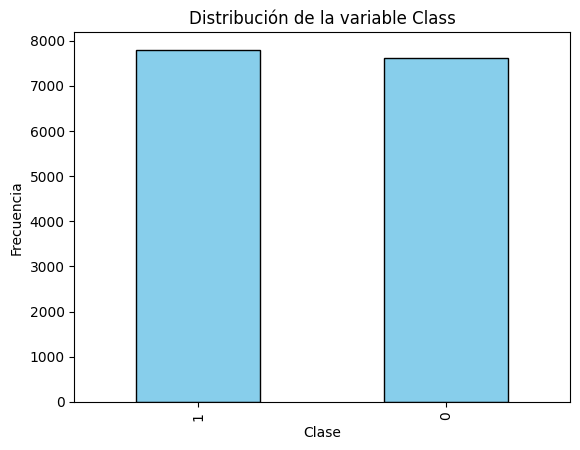

In [ ]:
datos_com['Class'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribución de la variable Class')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()


**Aplicar validación cruzada en los datos completos, es decir, con balance 50-50% sin alguna variante de smote**

---



**Regresión logística**

In [ ]:
# Validación cruzada en datos completos con regresión logística
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(datos_com, modelo_type='logit')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
    modelo="Regresión logística",
    smote="Sin SMOTE",
    escenario="Completos",
    desbalance="50-50%",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[721  41]
 [ 48 732]]
Exactitud (con umbral 50%) en Fold 1: 0.9423
MCC (con umbral 50%) en Fold 1: 0.8846
Exactitud (con umbral óptimo) Fold 1: 0.9423
MCC ( con umbral óptimo)en Fold 1: 0.8846
MCC-F1 score (Fold 1): 0.6683
Umbral óptimo: 0.5015 — MCC(Normalizado): 0.9423, F1: 0.9427

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[738  24]
 [ 51 729]]
Exactitud (con umbral 50%) en Fold 2: 0.9501
MCC (con umbral 50%) en Fold 2: 0.9002
Exactitud (con umbral óptimo) Fold 2: 0.9514
MCC ( con umbral óptimo)en Fold 2: 0.9033
MCC-F1 score (Fold 2): 0.6720
Umbral óptimo: 0.5823 — MCC(Normalizado): 0.9517, F1: 0.9511

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[711  51]
 [ 28 752]]
Exactitud (con umbral 50%) en Fold 3: 0.9462
MCC (con umbral 50%) en Fold 3: 0.8924
Exactitud (con umbral óptimo) Fold 3: 0.9488
MCC ( con umbral óptimo)en Fold 3: 0.8979
MCC-F1 score (Fold 3): 0.6702
Umbral óptimo: 0.4453 — MCC(Normalizado): 0.948

**Gradient Boosting**

In [ ]:
# Validación cruzada en datos completos con  Gradient Boosting
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(datos_com, modelo_type='gbm')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
    modelo="Gradient Boosting",
    smote="Sin SMOTE",
    escenario="Completos",
    desbalance="50-50%",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[722  40]
 [ 57 723]]
Exactitud (con umbral 50%) en Fold 1: 0.9351
MCC (con umbral 50%) en Fold 1: 0.8703
Exactitud (con umbral óptimo) Fold 1: 0.9371
MCC ( con umbral óptimo)en Fold 1: 0.8744
MCC-F1 score (Fold 1): 0.6674
Umbral óptimo: 0.5222 — MCC(Normalizado): 0.9372, F1: 0.9371

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[726  36]
 [ 43 737]]
Exactitud (con umbral 50%) en Fold 2: 0.9481
MCC (con umbral 50%) en Fold 2: 0.8962
Exactitud (con umbral óptimo) Fold 2: 0.9488
MCC ( con umbral óptimo)en Fold 2: 0.8976
MCC-F1 score (Fold 2): 0.6702
Umbral óptimo: 0.5088 — MCC(Normalizado): 0.9488, F1: 0.9491

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[713  49]
 [ 30 750]]
Exactitud (con umbral 50%) en Fold 3: 0.9468
MCC (con umbral 50%) en Fold 3: 0.8936
Exactitud (con umbral óptimo) Fold 3: 0.9488
MCC ( con umbral óptimo)en Fold 3: 0.8978
MCC-F1 score (Fold 3): 0.6701
Umbral óptimo: 0.4537 — MCC(Normalizado): 0.948

**Random Forest**

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(datos_com, modelo_type='rf')

guardar_resultados(
    nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
    modelo="Random Forest",
    smote="Sin SMOTE",
    escenario="Completos",
    desbalance="50-50%",
    exactitud_50=scores_50,
    mcc_50=mcc_scores_50,
    umbral=umbral,
    mcc_f1_scores=mcc_f1_scores,
    exactitud_opt=scores,
    mcc_opt=mcc_scores,
    confusion_elements=confusion_elements
)


=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[704  58]
 [ 50 730]]
Exactitud (con umbral 50%) en Fold 1: 0.9293
MCC (con umbral 50%) en Fold 1: 0.8587
Exactitud (con umbral óptimo) Fold 1: 0.9300
MCC ( con umbral óptimo)en Fold 1: 0.8599
MCC-F1 score (Fold 1): 0.8337
Umbral óptimo: 0.4500 — MCC(Normalizado): 0.9300, F1: 0.9311

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[733  29]
 [ 53 727]]
Exactitud (con umbral 50%) en Fold 2: 0.9416
MCC (con umbral 50%) en Fold 2: 0.8834
Exactitud (con umbral óptimo) Fold 2: 0.9468
MCC ( con umbral óptimo)en Fold 2: 0.8941
MCC-F1 score (Fold 2): 0.8485
Umbral óptimo: 0.5400 — MCC(Normalizado): 0.9471, F1: 0.9466

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[730  32]
 [ 51 729]]
Exactitud (con umbral 50%) en Fold 3: 0.9423
MCC (con umbral 50%) en Fold 3: 0.8846
Exactitud (con umbral óptimo) Fold 3: 0.9462
MCC ( con umbral óptimo)en Fold 3: 0.8926
MCC-F1 score (Fold 3): 0.8523
Umbral óptimo: 0.5900 — MCC(Normalizado): 0.946

In [ ]:
datos_com['Class'].value_counts()

,count
Class,
1,7796
0,7623


# Escenario 1: 75-25%

**Aplicar validación cruzada con tres variantes de smote en los tres modelos**

---

**Regresión logística**

In [ ]:
dta1 = datos_com.copy()

In [ ]:
dta1['Class'].value_counts()

,count
Class,
1,7796
0,7623


In [ ]:
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta1['Class'].value_counts())
df_reduced1 = reduce_class_2(dta1, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced1['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


***Stable SMOTE***

In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced1,
        smote_type="sstable",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5106
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[749  14]
 [ 24 171]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9676
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8986
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7547
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.5573
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9603
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8758
MCC-F1 score (Fold 1): 0.6038
Umbral óptimo: 0.9958 — MCC(Normalizado): 0.9379, F1: 0.9000

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5106
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[741  22]
 [ 30 165]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9572
MCC (datos de ent

In [ ]:
dta1['Class'].value_counts()

,count
Class,
1,7796
0,7623


***Stable TL***

In [ ]:
dta2 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta2['Class'].value_counts())
df_reduced2 = reduce_class_2(dta2, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced2['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced2,
        smote_type="smotetl",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 03:29:33,066:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:33,069:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===


2025-12-06 03:29:33,201:INFO:SMOTE: simplex sampling with n_dim 2
INFO:smote_variants:SMOTE: simplex sampling with n_dim 2
2025-12-06 03:29:33,232:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2025-12-06 03:29:33,234:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-06 03:29:33,238:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}


2025-12-06 03:29:39,452:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:39,455:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[753  10]
 [ 25 170]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9676
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8986
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7599
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.5661
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9635
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8851
MCC-F1 score (Fold 1): 0.6074
Umbral óptimo: 0.9984 — MCC(Normalizado): 0.9425, F1: 0.9067

=== Fold 2 ===
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}


2025-12-06 03:29:44,213:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:44,215:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[749  14]
 [ 29 166]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8648
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.7537
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.5562
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9551
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.8585
MCC-F1 score (Fold 2): 0.5983
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.9293, F1: 0.8853

=== Fold 3 ===
Distribución antes de SMOTE: {0: 6860, 1: 1755}
Distribución después de SMOTE: {0: 6853, 1: 6853}


2025-12-06 03:29:49,806:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:49,808:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[755   8]
 [ 25 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8845
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.7576
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.5630
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9655
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8912
MCC-F1 score (Fold 3): 0.6094
Umbral óptimo: 0.9980 — MCC(Normalizado): 0.9456, F1: 0.9111

=== Fold 4 ===


2025-12-06 03:29:49,972:INFO:SMOTE: simplex sampling with n_dim 2
INFO:smote_variants:SMOTE: simplex sampling with n_dim 2
2025-12-06 03:29:50,012:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2025-12-06 03:29:50,015:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-06 03:29:50,017:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6848, 1: 6848}


2025-12-06 03:29:55,270:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:29:55,273:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[746  16]
 [ 18 177]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9645
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8889
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.7638
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.5708
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9645
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8901
MCC-F1 score (Fold 4): 0.6095
Umbral óptimo: 0.9963 — MCC(Normalizado): 0.9451, F1: 0.9124

=== Fold 5 ===
Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}


2025-12-06 03:30:00,035:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:00,038:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[744  18]
 [ 33 162]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9415
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8143
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.7388
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.5426
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9467
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.8320
MCC-F1 score (Fold 5): 0.5881
Umbral óptimo: 0.9980 — MCC(Normalizado): 0.9160, F1: 0.8640

=== Fold 6 ===
Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}


2025-12-06 03:30:06,201:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:06,203:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[747  15]
 [ 18 177]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8848
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.7241
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.5269
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9655
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.8932
MCC-F1 score (Fold 6): 0.6099
Umbral óptimo: 0.9964 — MCC(Normalizado): 0.9466, F1: 0.9147

=== Fold 7 ===
Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}


2025-12-06 03:30:10,988:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:10,990:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[748  14]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9592
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8723
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.7429
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.5443
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9624
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.8826
MCC-F1 score (Fold 7): 0.6068
Umbral óptimo: 0.9973 — MCC(Normalizado): 0.9413, F1: 0.9058

=== Fold 8 ===
Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}


2025-12-06 03:30:16,042:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:16,047:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[747  15]
 [ 23 172]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9561
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8626
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.7576
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.5636
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9603
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.8760
MCC-F1 score (Fold 8): 0.6040
Umbral óptimo: 0.9973 — MCC(Normalizado): 0.9380, F1: 0.9005

=== Fold 9 ===


2025-12-06 03:30:16,197:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2025-12-06 03:30:16,200:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-06 03:30:16,205:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}


2025-12-06 03:30:22,197:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:30:22,200:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[746  16]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9551
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8599
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.7513
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.5565
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9603
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.8764
MCC-F1 score (Fold 9): 0.6040
Umbral óptimo: 0.9974 — MCC(Normalizado): 0.9382, F1: 0.9010

=== Fold 10 ===
Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[741  21]
 [ 14 181]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8712
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.7649
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.5692
Exactitud (SMOTE con umbral óptimo) Fold 10: 

In [ ]:
print(dta2['Class'].value_counts())

Class
1    7796
0    7623
Name: count, dtype: int64


***Stable IPF***

In [ ]:
dta3 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta3['Class'].value_counts())
df_reduced3 = reduce_class_2(dta3, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced3['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced3,
        smote_type="smoteipf",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 03:30:27,036:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:27,038:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2025-12-06 03:30:27,133:INFO:SMOTE: simplex sampling with n_dim 2
INFO:smote_variants:SMOTE: simplex sampling with n_dim 2
2025-12-06 03:30:27,827:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:28,516:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:29,220:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 03:30:33,982:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:33,985:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[753  10]
 [ 25 170]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9676
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8986
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7599
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.5661
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9635
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8851
MCC-F1 score (Fold 1): 0.6074
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.9425, F1: 0.9067

=== Fold 2 ===


2025-12-06 03:30:34,738:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:35,351:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:35,975:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 03:30:39,479:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:39,481:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[746  17]
 [ 27 168]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8648
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.7537
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.5562
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9541
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.8561
MCC-F1 score (Fold 2): 0.5973
Umbral óptimo: 0.9971 — MCC(Normalizado): 0.9280, F1: 0.8842

=== Fold 3 ===


2025-12-06 03:30:40,250:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:40,891:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:41,523:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 1755}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 03:30:45,697:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:45,701:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[755   8]
 [ 25 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8845
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.7576
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.5630
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9655
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8912
MCC-F1 score (Fold 3): 0.6094
Umbral óptimo: 0.9979 — MCC(Normalizado): 0.9456, F1: 0.9111

=== Fold 4 ===


2025-12-06 03:30:45,874:INFO:SMOTE: simplex sampling with n_dim 2
INFO:smote_variants:SMOTE: simplex sampling with n_dim 2
2025-12-06 03:30:46,806:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:47,657:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:48,318:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 03:30:51,821:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:51,823:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[746  16]
 [ 18 177]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9645
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8889
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.7649
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.5720
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9645
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8901
MCC-F1 score (Fold 4): 0.6095
Umbral óptimo: 0.9963 — MCC(Normalizado): 0.9451, F1: 0.9124

=== Fold 5 ===


2025-12-06 03:30:52,567:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:53,179:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:53,800:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 03:30:57,301:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:30:57,303:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[744  18]
 [ 33 162]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9415
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8143
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.7398
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.5438
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9467
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.8320
MCC-F1 score (Fold 5): 0.5882
Umbral óptimo: 0.9979 — MCC(Normalizado): 0.9160, F1: 0.8640

=== Fold 6 ===


2025-12-06 03:30:58,317:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:30:59,240:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:00,126:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 03:31:04,149:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:04,151:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[746  16]
 [ 17 178]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8848
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.7252
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.5280
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9655
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.8935
MCC-F1 score (Fold 6): 0.6094
Umbral óptimo: 0.9955 — MCC(Normalizado): 0.9468, F1: 0.9152

=== Fold 7 ===


2025-12-06 03:31:04,915:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:05,558:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:06,191:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 03:31:09,621:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:09,626:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[748  14]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9592
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8723
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.7440
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.5455
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9624
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.8826
MCC-F1 score (Fold 7): 0.6068
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.9413, F1: 0.9058

=== Fold 8 ===


2025-12-06 03:31:10,408:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:11,045:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:11,780:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 03:31:16,494:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:16,496:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[747  15]
 [ 23 172]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9561
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8626
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.7565
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.5624
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9603
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.8760
MCC-F1 score (Fold 8): 0.6040
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.9380, F1: 0.9005

=== Fold 9 ===


2025-12-06 03:31:17,279:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:17,936:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:18,579:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 03:31:22,109:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:31:22,111:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[745  17]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9551
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8599
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.7503
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.5553
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9592
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.8733
MCC-F1 score (Fold 9): 0.6026
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.9367, F1: 0.8987

=== Fold 10 ===


2025-12-06 03:31:22,896:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:23,547:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 03:31:24,201:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[741  21]
 [ 14 181]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8712
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.7649
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.5692
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9634
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.8890
MCC-F1 score (Fold 10): 0.6101
Umbral óptimo: 0.9964 — MCC(Normalizado): 0.9445, F1: 0.9118

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9586 ± 0.0069
MCC medio (datos de entrenamiento desbalanceados) : 0.8702 ± 0.0221
Exactitud media (SMOTE con umbral 50%) : 0.7517 ± 0.0118
MCC medio (SMOTE con umbral 50%) : 0.5561 ± 0.0129
Exactitud media (SMOTE con umbral óptimo) : 0.9605 ± 0.0057
MCC medio (SMOTE con umbral óptimo) : 0

**Gradient Boosting**

***Stable SMOTE***

In [ ]:
dta4 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta4['Class'].value_counts())
df_reduced4 = reduce_class_2(dta4, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced4['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced4,
        smote_type="sstable",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5106
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[723  40]
 [ 26 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9656
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8923
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7641
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.5682
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9311
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.7938
MCC-F1 score (Fold 1): 0.5870
Umbral óptimo: 0.9659 — MCC(Normalizado): 0.8969, F1: 0.8366

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5106
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[723  40]
 [ 26 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9520
MCC (datos de ent

***Stable TL***

In [ ]:
dta5 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta5['Class'].value_counts())
df_reduced5 = reduce_class_2(dta5, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced5['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced5,
        smote_type="smotetl",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 03:49:47,088:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:47,091:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[723  40]
 [ 31 164]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9656
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8923
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.5292
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.3513
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9259
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.7756
MCC-F1 score (Fold 1): 0.5858
Umbral óptimo: 0.9976 — MCC(Normalizado): 0.8878, F1: 0.8221

=== Fold 2 ===


2025-12-06 03:49:56,703:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:49:56,706:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[672  91]
 [ 16 179]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9520
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8488
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4175
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.2638
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8883
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.7148
MCC-F1 score (Fold 2): 0.5627
Umbral óptimo: 0.9978 — MCC(Normalizado): 0.8574, F1: 0.7699

=== Fold 3 ===


2025-12-06 03:50:06,793:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:06,796:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1755}
Distribución después de SMOTE: {0: 6853, 1: 6853}
Matriz de confusión (Umbral óptimo):
[[711  52]
 [ 24 170]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8846
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.3710
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.2268
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9206
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.7697
MCC-F1 score (Fold 3): 0.5711
Umbral óptimo: 0.9985 — MCC(Normalizado): 0.8849, F1: 0.8173

=== Fold 4 ===


2025-12-06 03:50:15,611:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:15,613:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6848, 1: 6848}
Matriz de confusión (Umbral óptimo):
[[706  56]
 [ 13 182]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8849
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4096
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2576
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9279
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8012
MCC-F1 score (Fold 4): 0.5879
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.9006, F1: 0.8406

=== Fold 5 ===


2025-12-06 03:50:25,367:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:25,369:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[727  35]
 [ 36 159]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9457
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8281
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.4013
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.2510
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9258
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.7709
MCC-F1 score (Fold 5): 0.5800
Umbral óptimo: 0.9989 — MCC(Normalizado): 0.8855, F1: 0.8175

=== Fold 6 ===


2025-12-06 03:50:35,527:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:35,530:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[723  39]
 [ 31 164]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9666
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8950
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4357
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.2780
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9269
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.7782
MCC-F1 score (Fold 6): 0.5810
Umbral óptimo: 0.9987 — MCC(Normalizado): 0.8891, F1: 0.8241

=== Fold 7 ===


2025-12-06 03:50:44,314:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:44,317:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[706  56]
 [ 29 166]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9603
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8754
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.5204
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.3443
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9112
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.7422
MCC-F1 score (Fold 7): 0.5659
Umbral óptimo: 0.9971 — MCC(Normalizado): 0.8711, F1: 0.7962

=== Fold 8 ===


2025-12-06 03:50:54,632:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:50:54,634:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[711  51]
 [ 26 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8664
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4190
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2649
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9195
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.7656
MCC-F1 score (Fold 8): 0.5811
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.8828, F1: 0.8145

=== Fold 9 ===


2025-12-06 03:51:04,577:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:51:04,580:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[693  69]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9561
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8638
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.4817
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.3139
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9049
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.7382
MCC-F1 score (Fold 9): 0.5612
Umbral óptimo: 0.9970 — MCC(Normalizado): 0.8691, F1: 0.7918

=== Fold 10 ===


2025-12-06 03:51:14,071:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 03:51:14,075:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[719  43]
 [ 25 170]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9603
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8776
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.5434
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.3628
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9289
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.7895
MCC-F1 score (Fold 10): 0.5774
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.8948, F1: 0.8333

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9590 ± 0.0062
MCC medio (datos de entrenamiento desbalanceados) : 0.8717 ± 0.0197
Exactitud media (SMOTE con umbral 50%) : 0.4529 ± 0.0577
MCC medio (SMOTE con umbral 50%) : 0.2914 ± 0.0454
Exactitud media (SMOTE con umbral óptimo) : 0.9180 ± 0.0124
MCC medio (SMOTE con umbral óptimo) : 0

***Stable IPF***

In [ ]:
dta6 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta6['Class'].value_counts())
df_reduced6 = reduce_class_2(dta6, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced6['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced6,
        smote_type="smoteipf",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 03:51:23,983:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:23,986:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[708  55]
 [ 21 174]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9656
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8923
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.5063
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.3331
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9207
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.7743
MCC-F1 score (Fold 1): 0.5805
Umbral óptimo: 0.9976 — MCC(Normalizado): 0.8872, F1: 0.8208

=== Fold 2 ===


2025-12-06 03:51:34,597:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:34,600:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[697  66]
 [ 26 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9520
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8488
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4175
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.2638
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9040
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.7301
MCC-F1 score (Fold 2): 0.5661
Umbral óptimo: 0.9981 — MCC(Normalizado): 0.8650, F1: 0.7860

=== Fold 3 ===


2025-12-06 03:51:45,489:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:45,491:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1755}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[740  23]
 [ 33 161]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8846
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.4033
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.2526
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9415
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8159
MCC-F1 score (Fold 3): 0.5932
Umbral óptimo: 0.9988 — MCC(Normalizado): 0.9079, F1: 0.8519

=== Fold 4 ===


2025-12-06 03:51:55,358:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:51:55,362:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[728  34]
 [ 26 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9634
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8849
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4535
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2919
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9373
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8099
MCC-F1 score (Fold 4): 0.5859
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.9050, F1: 0.8492

=== Fold 5 ===


2025-12-06 03:52:05,989:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:52:05,994:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[740  22]
 [ 46 149]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9457
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8281
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.4775
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.3106
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9289
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.7731
MCC-F1 score (Fold 5): 0.5795
Umbral óptimo: 0.9988 — MCC(Normalizado): 0.8865, F1: 0.8142

=== Fold 6 ===


2025-12-06 03:52:16,804:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:52:16,807:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[723  39]
 [ 29 166]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9666
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8950
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4222
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.2674
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9289
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.7855
MCC-F1 score (Fold 6): 0.5825
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.8928, F1: 0.8300

=== Fold 7 ===


2025-12-06 03:52:27,927:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:52:27,929:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[712  50]
 [ 30 165]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9603
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8754
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.5246
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.3477
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9164
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.7533
MCC-F1 score (Fold 7): 0.5718
Umbral óptimo: 0.9971 — MCC(Normalizado): 0.8766, F1: 0.8049

=== Fold 8 ===


2025-12-06 03:52:38,410:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:52:38,412:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[695  67]
 [ 18 177]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8664
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.4295
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2731
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9112
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.7576
MCC-F1 score (Fold 8): 0.5755
Umbral óptimo: 0.9977 — MCC(Normalizado): 0.8788, F1: 0.8064

=== Fold 9 ===


2025-12-06 03:52:49,048:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:52:49,051:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[699  63]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9561
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8638
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.5256
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.3485
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9112
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.7518
MCC-F1 score (Fold 9): 0.5699
Umbral óptimo: 0.9969 — MCC(Normalizado): 0.8759, F1: 0.8028

=== Fold 10 ===


2025-12-06 03:53:01,287:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 03:53:01,290:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[707  55]
 [ 17 178]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9603
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8776
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.5496
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.3678
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9248
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.7890
MCC-F1 score (Fold 10): 0.5829
Umbral óptimo: 0.9975 — MCC(Normalizado): 0.8945, F1: 0.8318

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9590 ± 0.0062
MCC medio (datos de entrenamiento desbalanceados) : 0.8717 ± 0.0197
Exactitud media (SMOTE con umbral 50%) : 0.4710 ± 0.0502
MCC medio (SMOTE con umbral 50%) : 0.3056 ± 0.0394
Exactitud media (SMOTE con umbral óptimo) : 0.9225 ± 0.0114
MCC medio (SMOTE con umbral óptimo) : 0

**Random Forest**

***Stable Smote***

In [ ]:
dta7 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta7['Class'].value_counts())
df_reduced7 = reduce_class_2(dta7, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced7['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced7,
        smote_type="sstable",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5106
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[689  74]
 [ 25 170]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8686
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7881
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.5970
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8967
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.7160
MCC-F1 score (Fold 1): 0.6798
Umbral óptimo: 0.8600 — MCC(Normalizado): 0.8580, F1: 0.7745

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5106
Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[690  73]
 [ 22 173]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9509
MCC (datos de ent

***Smote TL***

In [ ]:
dta8 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta8['Class'].value_counts())
df_reduced8  = reduce_class_2(dta8, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced8['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced8,
        smote_type="smotetl",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 04:11:08,619:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:08,623:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[692  71]
 [ 38 157]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8686
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2996
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.1648
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8862
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.6732
MCC-F1 score (Fold 1): 0.5949
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8366, F1: 0.7423

=== Fold 2 ===


2025-12-06 04:11:12,963:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:12,965:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[645 118]
 [ 30 165]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9509
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8450
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.2255
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0757
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8455
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.6103
MCC-F1 score (Fold 2): 0.5708
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8051, F1: 0.6904

=== Fold 3 ===


2025-12-06 04:11:17,382:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:17,385:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1755}
Distribución después de SMOTE: {0: 6853, 1: 6853}
Matriz de confusión (Umbral óptimo):
[[702  61]
 [ 25 169]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8642
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2288
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0826
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9101
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.7444
MCC-F1 score (Fold 3): 0.5933
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8722, F1: 0.7972

=== Fold 4 ===


2025-12-06 04:11:23,238:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:23,240:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6848, 1: 6848}
Matriz de confusión (Umbral óptimo):
[[710  52]
 [ 35 160]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8647
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.3062
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.1709
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9091
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.7297
MCC-F1 score (Fold 4): 0.5977
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8648, F1: 0.7862

=== Fold 5 ===


2025-12-06 04:11:27,562:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:27,565:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[663  99]
 [ 32 163]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9478
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8340
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2382
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0956
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8631
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.6377
MCC-F1 score (Fold 5): 0.5817
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8189, F1: 0.7133

=== Fold 6 ===


2025-12-06 04:11:31,857:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:31,861:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[658 104]
 [ 20 175]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8679
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2059
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0232
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8704
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.6744
MCC-F1 score (Fold 6): 0.5990
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8372, F1: 0.7384

=== Fold 7 ===


2025-12-06 04:11:37,763:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:37,766:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[658 104]
 [ 37 158]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9551
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8578
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2414
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1000
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8527
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.6086
MCC-F1 score (Fold 7): 0.5693
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8043, F1: 0.6915

=== Fold 8 ===


2025-12-06 04:11:42,261:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:42,264:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6849, 1: 6849}
Matriz de confusión (Umbral óptimo):
[[718  44]
 [ 36 159]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9551
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8583
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.3971
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2476
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9164
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.7465
MCC-F1 score (Fold 8): 0.5962
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8732, F1: 0.7990

=== Fold 9 ===


2025-12-06 04:11:47,059:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:47,064:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[686  76]
 [ 32 163]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9561
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8617
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.2184
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0616
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8871
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.6850
MCC-F1 score (Fold 9): 0.5896
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8425, F1: 0.7512

=== Fold 10 ===


2025-12-06 04:11:52,687:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:11:52,690:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6846, 1: 6846}
Matriz de confusión (Umbral óptimo):
[[659 103]
 [ 11 184]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9603
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8764
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.2299
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0829
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8809
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.7106
MCC-F1 score (Fold 10): 0.5915
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.8553, F1: 0.7635

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9556 ± 0.0035
MCC medio (datos de entrenamiento desbalanceados) : 0.8598 ± 0.0117
Exactitud media (SMOTE con umbral 50%) : 0.2591 ± 0.0557
MCC medio (SMOTE con umbral 50%) : 0.1105 ± 0.0620
Exactitud media (SMOTE con umbral óptimo) : 0.8822 ± 0.0233
MCC medio (SMOTE con umbral óptimo) : 0

***Stable IPF***

In [ ]:
dta9 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta9['Class'].value_counts())
df_reduced9  = reduce_class_2(dta9, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced9['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced9,
        smote_type="smoteipf",
        modelo_type="rf"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="75-25%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===


2025-12-06 04:11:57,146:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:11:57,150:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[642 121]
 [ 13 182]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8686
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2766
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.1419
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8601
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.6708
MCC-F1 score (Fold 1): 0.5917
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8354, F1: 0.7309

=== Fold 2 ===


2025-12-06 04:12:03,317:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:03,321:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1754}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[653 110]
 [ 29 166]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9509
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8450
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.2787
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.1441
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8549
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.6287
MCC-F1 score (Fold 2): 0.5787
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8143, F1: 0.7049

=== Fold 3 ===


2025-12-06 04:12:08,798:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:08,800:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1755}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[690  73]
 [ 29 165]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8642
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2926
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.1584
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8934
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.7020
MCC-F1 score (Fold 3): 0.5984
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8510, F1: 0.7639

=== Fold 4 ===


2025-12-06 04:12:14,036:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:14,039:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[721  41]
 [ 35 160]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9572
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8647
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.4504
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2894
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9206
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.7582
MCC-F1 score (Fold 4): 0.6114
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8791, F1: 0.8081

=== Fold 5 ===


2025-12-06 04:12:20,623:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:20,625:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[655 107]
 [ 23 172]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9478
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8340
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2717
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.1366
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8642
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.6573
MCC-F1 score (Fold 5): 0.5944
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8287, F1: 0.7257

=== Fold 6 ===


2025-12-06 04:12:25,917:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:25,920:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[677  85]
 [ 39 156]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9582
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8679
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2100
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0402
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8704
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.6389
MCC-F1 score (Fold 6): 0.5827
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8194, F1: 0.7156

=== Fold 7 ===


2025-12-06 04:12:32,474:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:32,476:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[622 140]
 [ 13 182]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9551
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8578
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2884
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1538
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8401
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.6390
MCC-F1 score (Fold 7): 0.5764
Umbral óptimo: 0.9700 — MCC(Normalizado): 0.8195, F1: 0.7041

=== Fold 8 ===


2025-12-06 04:12:37,697:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:37,701:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[681  81]
 [ 21 174]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9551
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8583
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.3668
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2232
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.8934
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.7161
MCC-F1 score (Fold 8): 0.6001
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8581, F1: 0.7733

=== Fold 9 ===


2025-12-06 04:12:43,035:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:43,038:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[624 138]
 [ 13 182]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9561
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8617
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.2957
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.1610
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8422
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.6422
MCC-F1 score (Fold 9): 0.5915
Umbral óptimo: 0.9800 — MCC(Normalizado): 0.8211, F1: 0.7068

=== Fold 10 ===


2025-12-06 04:12:49,131:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:12:49,134:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1754}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[664  98]
 [ 17 178]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9603
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8764
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.3448
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.2050
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8798
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.6973
MCC-F1 score (Fold 10): 0.5963
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.8486, F1: 0.7558

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9556 ± 0.0035
MCC medio (datos de entrenamiento desbalanceados) : 0.8598 ± 0.0117
Exactitud media (SMOTE con umbral 50%) : 0.3076 ± 0.0621
MCC medio (SMOTE con umbral 50%) : 0.1654 ± 0.0617
Exactitud media (SMOTE con umbral óptimo) : 0.8719 ± 0.0240
MCC medio (SMOTE con umbral óptimo) : 0

**Aplicar validación cruzada sin smote en los tres modelos**

---



In [ ]:
dta10 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta10['Class'].value_counts())
df_reduced10  = reduce_class_2(dta10, reduction_percentage=0.75)
print("\nDistribución de clases después de reducción:")
df_reduced10['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1949


In [ ]:
# Aplicar validación cruzada en el conjunto de entrenamiento del data frame reducido sin stable smote
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced10, modelo_type='logit' )

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Regresión logística",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="75-25%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[748  15]
 [ 14 181]]
Exactitud (con umbral 50%) en Fold 1: 0.9676
MCC (con umbral 50%) en Fold 1: 0.8986
Exactitud (con umbral óptimo) Fold 1: 0.9697
MCC ( con umbral óptimo)en Fold 1: 0.9068
MCC-F1 score (Fold 1): 0.6146
Umbral óptimo: 0.3816 — MCC(Normalizado): 0.9534, F1: 0.9258

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[751  12]
 [ 29 166]]
Exactitud (con umbral 50%) en Fold 2: 0.9572
MCC (con umbral 50%) en Fold 2: 0.8648
Exactitud (con umbral óptimo) Fold 2: 0.9572
MCC ( con umbral óptimo)en Fold 2: 0.8650
MCC-F1 score (Fold 2): 0.5995
Umbral óptimo: 0.4856 — MCC(Normalizado): 0.9325, F1: 0.8901

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[746  17]
 [ 17 177]]
Exactitud (con umbral 50%) en Fold 3: 0.9634
MCC (con umbral 50%) en Fold 3: 0.8845
Exactitud (con umbral óptimo) Fold 3: 0.9645
MCC ( con umbral óptimo)en Fold 3: 0.8901
MCC-F1 score (Fold 3): 0.6090
Umbral óptimo: 0.3790 — MCC(Normalizado): 0.945

In [ ]:
# Validación cruzada en datos completos
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced10, modelo_type='gbm')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="75-25%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[751  12]
 [ 21 174]]
Exactitud (con umbral 50%) en Fold 1: 0.9656
MCC (con umbral 50%) en Fold 1: 0.8923
Exactitud (con umbral óptimo) Fold 1: 0.9656
MCC ( con umbral óptimo)en Fold 1: 0.8923
MCC-F1 score (Fold 1): 0.6104
Umbral óptimo: 0.5088 — MCC(Normalizado): 0.9461, F1: 0.9134

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[751  12]
 [ 31 164]]
Exactitud (con umbral 50%) en Fold 2: 0.9520
MCC (con umbral 50%) en Fold 2: 0.8488
Exactitud (con umbral óptimo) Fold 2: 0.9551
MCC ( con umbral óptimo)en Fold 2: 0.8581
MCC-F1 score (Fold 2): 0.5989
Umbral óptimo: 0.6106 — MCC(Normalizado): 0.9290, F1: 0.8841

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[753  10]
 [ 25 169]]
Exactitud (con umbral 50%) en Fold 3: 0.9634
MCC (con umbral 50%) en Fold 3: 0.8846
Exactitud (con umbral óptimo) Fold 3: 0.9634
MCC ( con umbral óptimo)en Fold 3: 0.8846
MCC-F1 score (Fold 3): 0.6069
Umbral óptimo: 0.5054 — MCC(Normalizado): 0.942

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced10, modelo_type='rf')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Random Forest",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="75-25%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[752  11]
 [ 27 168]]
Exactitud (con umbral 50%) en Fold 1: 0.9582
MCC (con umbral 50%) en Fold 1: 0.8686
Exactitud (con umbral óptimo) Fold 1: 0.9603
MCC ( con umbral óptimo)en Fold 1: 0.8750
MCC-F1 score (Fold 1): 0.7588
Umbral óptimo: 0.5200 — MCC(Normalizado): 0.9375, F1: 0.8984

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[747  16]
 [ 27 168]]
Exactitud (con umbral 50%) en Fold 2: 0.9509
MCC (con umbral 50%) en Fold 2: 0.8450
Exactitud (con umbral óptimo) Fold 2: 0.9551
MCC ( con umbral óptimo)en Fold 2: 0.8592
MCC-F1 score (Fold 2): 0.7575
Umbral óptimo: 0.4500 — MCC(Normalizado): 0.9296, F1: 0.8865

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[748  15]
 [ 22 172]]
Exactitud (con umbral 50%) en Fold 3: 0.9572
MCC (con umbral 50%) en Fold 3: 0.8642
Exactitud (con umbral óptimo) Fold 3: 0.9613
MCC ( con umbral óptimo)en Fold 3: 0.8790
MCC-F1 score (Fold 3): 0.7670
Umbral óptimo: 0.4200 — MCC(Normalizado): 0.939

# Escenario 2: 85-15%

**Aplicar validación cruzada con tres variantes de smote en los tres modelos**

---

**Regresión logística**

***Stable Smote***

In [ ]:
dta11 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta11['Class'].value_counts())
df_reduced11  = reduce_class_2(dta11, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced11['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced11,
        smote_type="sstable",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5808
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[753  10]
 [ 16 101]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8628
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.6670
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.4193
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9705
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8694
MCC-F1 score (Fold 1): 0.5935
Umbral óptimo: 0.9991 — MCC(Normalizado): 0.9347, F1: 0.8860

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5808
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[756   7]
 [ 19  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9716
MCC (datos de ent

***Smote TL***

In [ ]:
dta12 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta12['Class'].value_counts())
df_reduced12 = reduce_class_2(dta12, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced12['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced12,
        smote_type="smotetl",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:24:19,621:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:19,624:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6858, 1: 6858}


2025-12-06 04:24:24,555:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:24,559:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[745  18]
 [ 12 105]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8628
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.6818
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.4319
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9659
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8556
MCC-F1 score (Fold 1): 0.5889
Umbral óptimo: 0.9991 — MCC(Normalizado): 0.9278, F1: 0.8750

=== Fold 2 ===


2025-12-06 04:24:24,703:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2025-12-06 04:24:24,706:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-06 04:24:24,709:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6854, 1: 6854}


2025-12-06 04:24:30,138:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:30,141:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[758   5]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9716
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8741
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.6761
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.4270
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9750
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.8883
MCC-F1 score (Fold 2): 0.6005
Umbral óptimo: 0.9998 — MCC(Normalizado): 0.9442, F1: 0.9009

=== Fold 3 ===
Distribución antes de SMOTE: {0: 6860, 1: 1053}
Distribución después de SMOTE: {0: 6857, 1: 6857}


2025-12-06 04:24:34,528:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:34,531:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[756   7]
 [ 14 102]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9716
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8726
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.6633
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.4103
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9761
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8936
MCC-F1 score (Fold 3): 0.6029
Umbral óptimo: 0.9996 — MCC(Normalizado): 0.9468, F1: 0.9067

=== Fold 4 ===
Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6852, 1: 6852}


2025-12-06 04:24:39,703:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:39,706:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[755   7]
 [ 21  96]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8677
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.6803
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.4308
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9681
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8569
MCC-F1 score (Fold 4): 0.5893
Umbral óptimo: 0.9998 — MCC(Normalizado): 0.9284, F1: 0.8727

=== Fold 5 ===
Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}


2025-12-06 04:24:44,868:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:44,871:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[749  13]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9647
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8456
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.6689
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.4210
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9647
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.8446
MCC-F1 score (Fold 5): 0.5847
Umbral óptimo: 0.9997 — MCC(Normalizado): 0.9223, F1: 0.8646

=== Fold 6 ===
Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6859, 1: 6859}


2025-12-06 04:24:49,296:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:49,298:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[753   9]
 [ 14 103]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8670
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.6405
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.3977
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9738
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.8848
MCC-F1 score (Fold 6): 0.5997
Umbral óptimo: 0.9995 — MCC(Normalizado): 0.9424, F1: 0.8996

=== Fold 7 ===
Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}


2025-12-06 04:24:55,033:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:55,037:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[748  14]
 [ 14 103]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8240
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.6689
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.4210
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9681
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.8620
MCC-F1 score (Fold 7): 0.5912
Umbral óptimo: 0.9991 — MCC(Normalizado): 0.9310, F1: 0.8803

=== Fold 8 ===


2025-12-06 04:24:55,186:INFO:TomekLinkRemoval: Running noise removal.
INFO:smote_variants:TomekLinkRemoval: Running noise removal.
2025-12-06 04:24:55,188:INFO:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: NN fitting with metric minkowski
2025-12-06 04:24:55,191:INFO:NearestNeighborsWithMetricTensor: kneighbors query minkowski
INFO:smote_variants:NearestNeighborsWithMetricTensor: kneighbors query minkowski


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}


2025-12-06 04:24:59,796:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:24:59,799:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[745  17]
 [ 16 101]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9647
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8405
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.6746
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.4259
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9625
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.8379
MCC-F1 score (Fold 8): 0.5817
Umbral óptimo: 0.9994 — MCC(Normalizado): 0.9190, F1: 0.8596

=== Fold 9 ===
Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6853, 1: 6853}


2025-12-06 04:25:04,236:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:25:04,239:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[760   2]
 [ 24  93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9670
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8531
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.6746
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.4259
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9704
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.8668
MCC-F1 score (Fold 9): 0.5925
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9334, F1: 0.8774

=== Fold 10 ===
Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6857, 1: 6857}
Matriz de confusión (Umbral óptimo):
[[757   5]
 [ 24  93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8682
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.6997
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.4480
Exactitud (SMOTE con umbral óptimo) Fold 10: 

***Stable IPF***

In [ ]:
dta13 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta13['Class'].value_counts())
df_reduced13  = reduce_class_2(dta13, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced13['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced13,
        smote_type="smoteipf",
        modelo_type="logit"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:25:10,168:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:10,170:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2025-12-06 04:25:10,969:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:11,667:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:12,375:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:25:15,526:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:15,528:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[745  18]
 [ 12 105]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8628
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.6830
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.4329
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9659
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8556
MCC-F1 score (Fold 1): 0.5889
Umbral óptimo: 0.9991 — MCC(Normalizado): 0.9278, F1: 0.8750

=== Fold 2 ===


2025-12-06 04:25:16,269:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:16,917:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:17,565:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:25:21,354:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:21,357:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[758   5]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9716
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8741
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.6750
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.4260
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9750
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.8883
MCC-F1 score (Fold 2): 0.6005
Umbral óptimo: 0.9998 — MCC(Normalizado): 0.9442, F1: 0.9009

=== Fold 3 ===


2025-12-06 04:25:22,458:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:23,426:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:24,142:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 1053}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:25:27,290:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:27,292:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[756   7]
 [ 14 102]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9716
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8726
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.6633
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.4103
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9761
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8936
MCC-F1 score (Fold 3): 0.6029
Umbral óptimo: 0.9996 — MCC(Normalizado): 0.9468, F1: 0.9067

=== Fold 4 ===


2025-12-06 04:25:28,109:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:28,840:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:29,538:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:25:32,657:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:32,660:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[743  19]
 [ 12 105]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8677
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.6815
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.4318
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9647
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8514
MCC-F1 score (Fold 4): 0.5872
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.9257, F1: 0.8714

=== Fold 5 ===


2025-12-06 04:25:33,431:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:34,337:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:35,258:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:25:39,117:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:39,122:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[749  13]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9647
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8456
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.6689
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.4210
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9647
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.8446
MCC-F1 score (Fold 5): 0.5847
Umbral óptimo: 0.9997 — MCC(Normalizado): 0.9223, F1: 0.8646

=== Fold 6 ===


2025-12-06 04:25:39,940:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:40,654:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:41,377:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:25:44,509:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:44,511:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[753   9]
 [ 14 103]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8670
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.6405
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.3977
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9738
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.8848
MCC-F1 score (Fold 6): 0.5997
Umbral óptimo: 0.9995 — MCC(Normalizado): 0.9424, F1: 0.8996

=== Fold 7 ===


2025-12-06 04:25:45,283:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:45,980:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:46,667:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:25:51,007:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:51,014:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[749  13]
 [ 15 102]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8240
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.6689
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.4210
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9681
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.8610
MCC-F1 score (Fold 7): 0.5907
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.9305, F1: 0.8793

=== Fold 8 ===


2025-12-06 04:25:51,910:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:52,612:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:53,298:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:25:56,439:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:25:56,441:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[744  18]
 [ 15 102]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9647
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8405
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.6746
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.4259
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9625
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.8392
MCC-F1 score (Fold 8): 0.5821
Umbral óptimo: 0.9992 — MCC(Normalizado): 0.9196, F1: 0.8608

=== Fold 9 ===


2025-12-06 04:25:57,240:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:57,941:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:25:58,655:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:26:02,024:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:26:02,027:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[760   2]
 [ 24  93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9670
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8531
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.6758
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.4268
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9704
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.8668
MCC-F1 score (Fold 9): 0.5925
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9334, F1: 0.8774

=== Fold 10 ===


2025-12-06 04:26:03,132:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:26:04,095:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:26:05,089:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[757   5]
 [ 24  93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8682
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.6997
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.4480
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9670
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.8508
MCC-F1 score (Fold 10): 0.5874
Umbral óptimo: 0.9998 — MCC(Normalizado): 0.9254, F1: 0.8651

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9682 ± 0.0033
MCC medio (datos de entrenamiento desbalanceados) : 0.8576 ± 0.0155
Exactitud media (SMOTE con umbral 50%) : 0.6731 ± 0.0144
MCC medio (SMOTE con umbral 50%) : 0.4241 ± 0.0128
Exactitud media (SMOTE con umbral óptimo) : 0.9688 ± 0.0045
MCC medio (SMOTE con umbral óptimo) : 0

**Gradient Boosting**

***Stable Smote***

In [ ]:
dta14 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta14['Class'].value_counts())
df_reduced14 = reduce_class_2(dta14, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced14['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced14,
        smote_type="sstable",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===
Número de instancias minoritarias necesarias: 5808
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[727  36]
 [ 26  91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9682
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8579
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7080
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.4555
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9295
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.7059
MCC-F1 score (Fold 1): 0.5395
Umbral óptimo: 0.9844 — MCC(Normalizado): 0.8529, F1: 0.7459

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5808
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[711  52]
 [ 10 107]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9705
MCC (datos de ent

***Smote TL***

In [ ]:
dta15 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta15['Class'].value_counts())
df_reduced15  = reduce_class_2(dta15, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced15['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced15,
        smote_type="smotetl",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 04:36:02,676:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:02,679:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6858, 1: 6858}
Matriz de confusión (Umbral óptimo):
[[645 118]
 [ 11 106]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9682
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8579
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.3830
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2261
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8534
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.5856
MCC-F1 score (Fold 1): 0.4862
Umbral óptimo: 0.9971 — MCC(Normalizado): 0.7928, F1: 0.6217

=== Fold 2 ===


2025-12-06 04:36:12,997:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:12,999:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6854, 1: 6854}
Matriz de confusión (Umbral óptimo):
[[721  42]
 [ 24  93]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9705
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8701
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.4057
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.2398
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9250
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.6970
MCC-F1 score (Fold 2): 0.5288
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.8485, F1: 0.7381

=== Fold 3 ===


2025-12-06 04:36:23,053:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:23,055:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1053}
Distribución después de SMOTE: {0: 6857, 1: 6857}
Matriz de confusión (Umbral óptimo):
[[639 124]
 [  7 109]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8623
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.3720
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.2191
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8510
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.5959
MCC-F1 score (Fold 3): 0.4971
Umbral óptimo: 0.9979 — MCC(Normalizado): 0.7980, F1: 0.6246

=== Fold 4 ===


2025-12-06 04:36:32,181:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:32,184:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6852, 1: 6852}
Matriz de confusión (Umbral óptimo):
[[691  71]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8677
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.3527
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2078
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8987
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.6476
MCC-F1 score (Fold 4): 0.5212
Umbral óptimo: 0.9985 — MCC(Normalizado): 0.8238, F1: 0.6899

=== Fold 5 ===


2025-12-06 04:36:42,372:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:42,375:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}
Matriz de confusión (Umbral óptimo):
[[694  68]
 [ 31  86]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8301
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2981
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.1742
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8874
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.5771
MCC-F1 score (Fold 5): 0.4869
Umbral óptimo: 0.9987 — MCC(Normalizado): 0.7885, F1: 0.6347

=== Fold 6 ===


2025-12-06 04:36:52,565:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:36:52,568:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[674  88]
 [ 15 102]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8670
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.4403
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.2609
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8828
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.6241
MCC-F1 score (Fold 6): 0.5095
Umbral óptimo: 0.9969 — MCC(Normalizado): 0.8121, F1: 0.6645

=== Fold 7 ===


2025-12-06 04:37:02,723:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:02,726:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}
Matriz de confusión (Umbral óptimo):
[[697  65]
 [ 35  82]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9670
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8519
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.3333
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1961
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8862
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.5603
MCC-F1 score (Fold 7): 0.4902
Umbral óptimo: 0.9985 — MCC(Normalizado): 0.7802, F1: 0.6212

=== Fold 8 ===


2025-12-06 04:37:11,969:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:11,971:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}
Matriz de confusión (Umbral óptimo):
[[714  48]
 [ 30  87]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8250
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2856
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.1662
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9113
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.6412
MCC-F1 score (Fold 8): 0.5246
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.8206, F1: 0.6905

=== Fold 9 ===


2025-12-06 04:37:22,030:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:22,033:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6853, 1: 6853}
Matriz de confusión (Umbral óptimo):
[[704  58]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9625
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8346
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.3106
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.1820
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9147
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.6888
MCC-F1 score (Fold 9): 0.5310
Umbral óptimo: 0.9989 — MCC(Normalizado): 0.8444, F1: 0.7273

=== Fold 10 ===


2025-12-06 04:37:32,226:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:37:32,228:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6857, 1: 6857}
Matriz de confusión (Umbral óptimo):
[[694  68]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8647
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4846
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.2885
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9033
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.6613
MCC-F1 score (Fold 10): 0.5225
Umbral óptimo: 0.9980 — MCC(Normalizado): 0.8307, F1: 0.7018

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9670 ± 0.0036
MCC medio (datos de entrenamiento desbalanceados) : 0.8531 ± 0.0161
Exactitud media (SMOTE con umbral 50%) : 0.3666 ± 0.0607
MCC medio (SMOTE con umbral 50%) : 0.2161 ± 0.0372
Exactitud media (SMOTE con umbral óptimo) : 0.8914 ± 0.0234
MCC medio (SMOTE con umbral óptimo) : 0

***Stable IPF***

In [ ]:
dta16 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta16['Class'].value_counts())
df_reduced16  = reduce_class_2(dta16, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced16['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced16,
        smote_type="smoteipf",
        modelo_type="gbm"
    )
guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 04:37:41,247:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:37:41,250:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[666  97]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9682
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8579
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.4216
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2494
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8693
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.5867
MCC-F1 score (Fold 1): 0.4958
Umbral óptimo: 0.9972 — MCC(Normalizado): 0.7934, F1: 0.6326

=== Fold 2 ===


2025-12-06 04:37:52,420:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:37:52,423:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[703  60]
 [ 20  97]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9705
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8701
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.3920
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.2316
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9091
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.6655
MCC-F1 score (Fold 2): 0.5261
Umbral óptimo: 0.9984 — MCC(Normalizado): 0.8327, F1: 0.7080

=== Fold 3 ===


2025-12-06 04:38:03,156:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:03,159:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1053}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[677  86]
 [ 18  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8623
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.3197
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.1874
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8817
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.6091
MCC-F1 score (Fold 3): 0.5066
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.8045, F1: 0.6533

=== Fold 4 ===


2025-12-06 04:38:14,328:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:14,330:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[691  71]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8677
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.3720
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2195
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8999
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.6535
MCC-F1 score (Fold 4): 0.5237
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.8267, F1: 0.6944

=== Fold 5 ===


2025-12-06 04:38:24,762:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:24,765:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[661 101]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8301
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.2958
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.1727
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8646
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.5782
MCC-F1 score (Fold 5): 0.4881
Umbral óptimo: 0.9982 — MCC(Normalizado): 0.7891, F1: 0.6246

=== Fold 6 ===


2025-12-06 04:38:35,309:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:35,312:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[676  86]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9704
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8670
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.3777
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.2230
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8828
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.6170
MCC-F1 score (Fold 6): 0.5113
Umbral óptimo: 0.9976 — MCC(Normalizado): 0.8085, F1: 0.6601

=== Fold 7 ===


2025-12-06 04:38:46,185:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:46,190:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[693  69]
 [ 25  92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9670
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8519
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.3572
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.2106
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8931
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.6110
MCC-F1 score (Fold 7): 0.5119
Umbral óptimo: 0.9983 — MCC(Normalizado): 0.8055, F1: 0.6619

=== Fold 8 ===


2025-12-06 04:38:57,369:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:38:57,372:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[705  57]
 [ 25  92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8250
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2708
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.1566
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9067
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.6442
MCC-F1 score (Fold 8): 0.5274
Umbral óptimo: 0.9985 — MCC(Normalizado): 0.8221, F1: 0.6917

=== Fold 9 ===


2025-12-06 04:39:07,901:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:39:07,904:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[693  69]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9625
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8346
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.3402
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.2002
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9010
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.6528
MCC-F1 score (Fold 9): 0.5195
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.8264, F1: 0.6947

=== Fold 10 ===


2025-12-06 04:39:18,230:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:39:18,232:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[680  82]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8647
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.4562
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.2707
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8874
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.6263
MCC-F1 score (Fold 10): 0.5064
Umbral óptimo: 0.9979 — MCC(Normalizado): 0.8132, F1: 0.6689

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9670 ± 0.0036
MCC medio (datos de entrenamiento desbalanceados) : 0.8531 ± 0.0161
Exactitud media (SMOTE con umbral 50%) : 0.3603 ± 0.0535
MCC medio (SMOTE con umbral 50%) : 0.2122 ± 0.0328
Exactitud media (SMOTE con umbral óptimo) : 0.8896 ± 0.0144
MCC medio (SMOTE con umbral óptimo) : 0

**Random Forest**

***Stable Smote***

In [ ]:
dta17 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta17['Class'].value_counts())
df_reduced17  = reduce_class_2(dta17, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced17['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced17,
        smote_type="sstable",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===
Número de instancias minoritarias necesarias: 5808
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[697  66]
 [ 25  92]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9659
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8454
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7511
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.4893
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8966
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.6191
MCC-F1 score (Fold 1): 0.5780
Umbral óptimo: 0.9100 — MCC(Normalizado): 0.8095, F1: 0.6691

=== Fold 2 ===
Número de instancias minoritarias necesarias: 5808
Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[688  75]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9648
MCC (datos de ent

***Smote TL***

In [ ]:
dta18 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta18['Class'].value_counts())
df_reduced18  = reduce_class_2(dta18, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced18['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced18,
        smote_type="smotetl",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 04:48:59,071:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:48:59,074:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6858, 1: 6858}
Matriz de confusión (Umbral óptimo):
[[674  89]
 [ 16 101]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9659
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8454
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.3545
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2089
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8807
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.6161
MCC-F1 score (Fold 1): 0.4867
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8080, F1: 0.6580

=== Fold 2 ===


2025-12-06 04:49:03,420:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:03,422:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6854, 1: 6854}
Matriz de confusión (Umbral óptimo):
[[667  96]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9648
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8405
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1625
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0683
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8705
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.5889
MCC-F1 score (Fold 2): 0.4977
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7944, F1: 0.6346

=== Fold 3 ===


2025-12-06 04:49:07,743:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:07,745:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 1053}
Distribución después de SMOTE: {0: 6857, 1: 6857}
Matriz de confusión (Umbral óptimo):
[[685  78]
 [ 25  91]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9647
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8393
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2696
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.1558
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8828
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.5860
MCC-F1 score (Fold 3): 0.4836
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7930, F1: 0.6386

=== Fold 4 ===


2025-12-06 04:49:13,447:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:13,449:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6852, 1: 6852}
Matriz de confusión (Umbral óptimo):
[[667  95]
 [ 20  97]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8236
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.1661
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0724
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8692
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.5791
MCC-F1 score (Fold 4): 0.4846
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7895, F1: 0.6278

=== Fold 5 ===


2025-12-06 04:49:17,767:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:17,770:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}
Matriz de confusión (Umbral óptimo):
[[661 101]
 [ 11 106]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9590
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8145
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1684
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0749
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8726
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.6192
MCC-F1 score (Fold 5): 0.4917
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8096, F1: 0.6543

=== Fold 6 ===


2025-12-06 04:49:22,031:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:22,033:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[672  90]
 [ 19  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8614
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2571
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.1474
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8760
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.5960
MCC-F1 score (Fold 6): 0.4773
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7980, F1: 0.6426

=== Fold 7 ===


2025-12-06 04:49:27,862:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:27,865:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}
Matriz de confusión (Umbral óptimo):
[[659 103]
 [ 16 101]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9625
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8295
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2287
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1274
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8646
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.5858
MCC-F1 score (Fold 7): 0.4819
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7929, F1: 0.6293

=== Fold 8 ===


2025-12-06 04:49:32,208:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:32,211:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6856, 1: 6856}
Matriz de confusión (Umbral óptimo):
[[684  78]
 [ 27  90]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9636
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8343
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.3481
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2051
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.8805
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.5761
MCC-F1 score (Fold 8): 0.4870
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7881, F1: 0.6316

=== Fold 9 ===


2025-12-06 04:49:36,601:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:36,604:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6853, 1: 6853}
Matriz de confusión (Umbral óptimo):
[[643 119]
 [ 12 105]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9636
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8367
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1684
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0749
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8510
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.5778
MCC-F1 score (Fold 9): 0.4894
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7889, F1: 0.6158

=== Fold 10 ===


2025-12-06 04:49:42,420:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:49:42,422:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6857, 1: 6857}
Matriz de confusión (Umbral óptimo):
[[660 102]
 [ 19  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9625
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8292
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.2992
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.1749
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8623
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.5702
MCC-F1 score (Fold 10): 0.4921
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7851, F1: 0.6183

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9637 ± 0.0026
MCC medio (datos de entrenamiento desbalanceados) : 0.8354 ± 0.0121
Exactitud media (SMOTE con umbral 50%) : 0.2423 ± 0.0716
MCC medio (SMOTE con umbral 50%) : 0.1310 ± 0.0530
Exactitud media (SMOTE con umbral óptimo) : 0.8710 ± 0.0093
MCC medio (SMOTE con umbral óptimo) : 0

***Stable IPF***

In [ ]:
dta19 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta19['Class'].value_counts())
df_reduced19  = reduce_class_2(dta19, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced19['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced = aplicar_validacion_cruzada_smote(
        df_reduced19,
        smote_type="smoteipf",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="85-15%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 04:49:46,853:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:49:46,856:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[677  86]
 [ 19  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9659
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8454
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.2364
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.1330
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8807
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.6052
MCC-F1 score (Fold 1): 0.4858
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8026, F1: 0.6512

=== Fold 2 ===


2025-12-06 04:49:52,740:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:49:52,744:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1052}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[667  96]
 [ 17 100]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9648
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.8405
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1943
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.1001
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8716
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.5948
MCC-F1 score (Fold 2): 0.4881
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7974, F1: 0.6390

=== Fold 3 ===


2025-12-06 04:49:58,386:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:49:58,388:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 1053}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[637 126]
 [ 12 104]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9647
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8393
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.2412
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.1365
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8430
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.5632
MCC-F1 score (Fold 3): 0.4779
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.7816, F1: 0.6012

=== Fold 4 ===


2025-12-06 04:50:03,651:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:03,654:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[658 104]
 [ 13 104]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9613
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8236
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.2321
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.1299
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8669
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.6014
MCC-F1 score (Fold 4): 0.4803
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8007, F1: 0.6400

=== Fold 5 ===


2025-12-06 04:50:10,038:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:10,041:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[672  90]
 [ 19  98]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9590
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8145
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1832
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0899
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8760
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.5960
MCC-F1 score (Fold 5): 0.4890
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7980, F1: 0.6426

=== Fold 6 ===


2025-12-06 04:50:15,189:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:15,191:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[697  65]
 [ 23  94]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9693
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.8614
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.2400
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.1356
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8999
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.6337
MCC-F1 score (Fold 6): 0.4745
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8169, F1: 0.6812

=== Fold 7 ===


2025-12-06 04:50:21,174:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:21,177:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[671  91]
 [ 22  95]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9625
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8295
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.2628
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.1513
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8714
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.5760
MCC-F1 score (Fold 7): 0.4781
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7880, F1: 0.6271

=== Fold 8 ===


2025-12-06 04:50:26,856:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:26,859:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[688  74]
 [ 20  97]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9636
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8343
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.3481
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2051
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.8931
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.6281
MCC-F1 score (Fold 8): 0.4859
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8141, F1: 0.6736

=== Fold 9 ===


2025-12-06 04:50:32,060:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:32,062:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[650 112]
 [ 18  99]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9636
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8367
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1399
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0325
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8521
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.5561
MCC-F1 score (Fold 9): 0.4859
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7780, F1: 0.6037

=== Fold 10 ===


2025-12-06 04:50:38,405:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:50:38,408:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 1052}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[638 124]
 [ 10 107]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9625
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.8292
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.3606
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.2061
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8476
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.5802
MCC-F1 score (Fold 10): 0.4875
Umbral óptimo: 0.9900 — MCC(Normalizado): 0.7901, F1: 0.6149

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9637 ± 0.0026
MCC medio (datos de entrenamiento desbalanceados) : 0.8354 ± 0.0121
Exactitud media (SMOTE con umbral 50%) : 0.2439 ± 0.0648
MCC medio (SMOTE con umbral 50%) : 0.1320 ± 0.0489
Exactitud media (SMOTE con umbral óptimo) : 0.8702 ± 0.0177
MCC medio (SMOTE con umbral óptimo) : 0

**Aplicar validación cruzada sin smote en los tres modelos**

---



In [ ]:
dta20 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta20['Class'].value_counts())
df_reduced20  = reduce_class_2(dta20, reduction_percentage=0.85)
print("\nDistribución de clases después de reducción:")
df_reduced20['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,1169


In [ ]:
# Aplicar validación cruzada en el conjunto de entrenamiento del data frame reducido sin stable smote
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced20, modelo_type='logit' )

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Regresión logística",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="85-15%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[749  14]
 [ 11 106]]
Exactitud (con umbral 50%) en Fold 1: 0.9693
MCC (con umbral 50%) en Fold 1: 0.8628
Exactitud (con umbral óptimo) Fold 1: 0.9716
MCC ( con umbral óptimo)en Fold 1: 0.8782
MCC-F1 score (Fold 1): 0.5966
Umbral óptimo: 0.3003 — MCC(Normalizado): 0.9391, F1: 0.8945

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[754   9]
 [ 13 104]]
Exactitud (con umbral 50%) en Fold 2: 0.9716
MCC (con umbral 50%) en Fold 2: 0.8741
Exactitud (con umbral óptimo) Fold 2: 0.9750
MCC ( con umbral óptimo)en Fold 2: 0.8902
MCC-F1 score (Fold 2): 0.6013
Umbral óptimo: 0.4087 — MCC(Normalizado): 0.9451, F1: 0.9043

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[750  13]
 [ 10 106]]
Exactitud (con umbral 50%) en Fold 3: 0.9716
MCC (con umbral 50%) en Fold 3: 0.8726
Exactitud (con umbral óptimo) Fold 3: 0.9738
MCC ( con umbral óptimo)en Fold 3: 0.8871
MCC-F1 score (Fold 3): 0.6004
Umbral óptimo: 0.3210 — MCC(Normalizado): 0.943

In [ ]:
# Validación cruzada en datos completos
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced20, modelo_type='gbm')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="85-15%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[754   9]
 [ 16 101]]
Exactitud (con umbral 50%) en Fold 1: 0.9682
MCC (con umbral 50%) en Fold 1: 0.8579
Exactitud (con umbral óptimo) Fold 1: 0.9716
MCC ( con umbral óptimo)en Fold 1: 0.8741
MCC-F1 score (Fold 1): 0.5949
Umbral óptimo: 0.3946 — MCC(Normalizado): 0.9371, F1: 0.8899

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[753  10]
 [ 15 102]]
Exactitud (con umbral 50%) en Fold 2: 0.9705
MCC (con umbral 50%) en Fold 2: 0.8701
Exactitud (con umbral óptimo) Fold 2: 0.9716
MCC ( con umbral óptimo)en Fold 2: 0.8748
MCC-F1 score (Fold 2): 0.5959
Umbral óptimo: 0.5400 — MCC(Normalizado): 0.9374, F1: 0.8908

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[757   6]
 [ 20  96]]
Exactitud (con umbral 50%) en Fold 3: 0.9693
MCC (con umbral 50%) en Fold 3: 0.8623
Exactitud (con umbral óptimo) Fold 3: 0.9704
MCC ( con umbral óptimo)en Fold 3: 0.8663
MCC-F1 score (Fold 3): 0.5924
Umbral óptimo: 0.6224 — MCC(Normalizado): 0.933

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced20, modelo_type='rf')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Random Forest",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="85-15%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[752  11]
 [ 15 102]]
Exactitud (con umbral 50%) en Fold 1: 0.9659
MCC (con umbral 50%) en Fold 1: 0.8454
Exactitud (con umbral óptimo) Fold 1: 0.9705
MCC ( con umbral óptimo)en Fold 1: 0.8701
MCC-F1 score (Fold 1): 0.7419
Umbral óptimo: 0.3400 — MCC(Normalizado): 0.9351, F1: 0.8870

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[748  15]
 [ 14 103]]
Exactitud (con umbral 50%) en Fold 2: 0.9648
MCC (con umbral 50%) en Fold 2: 0.8405
Exactitud (con umbral óptimo) Fold 2: 0.9670
MCC ( con umbral óptimo)en Fold 2: 0.8576
MCC-F1 score (Fold 2): 0.7308
Umbral óptimo: 0.3600 — MCC(Normalizado): 0.9288, F1: 0.8766

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[750  13]
 [ 14 102]]
Exactitud (con umbral 50%) en Fold 3: 0.9647
MCC (con umbral 50%) en Fold 3: 0.8393
Exactitud (con umbral óptimo) Fold 3: 0.9693
MCC ( con umbral óptimo)en Fold 3: 0.8654
MCC-F1 score (Fold 3): 0.7274
Umbral óptimo: 0.3500 — MCC(Normalizado): 0.932

# Escenario 3: 95-5%

**Aplicar validación cruzada con tres variantes de smote en los tres modelos**

---

**Regresión logística**

***Stable Smote***

In [ ]:
dta21 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta21['Class'].value_counts())
df_reduced21  = reduce_class_2(dta21, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced21['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced21,
        smote_type="sstable",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)


=== Fold 1 ===
Número de instancias minoritarias necesarias: 6510
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[761   2]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.5773
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2394
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9838
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8108
MCC-F1 score (Fold 1): 0.5330
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9054, F1: 0.8116

=== Fold 2 ===
Número de instancias minoritarias necesarias: 6510
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[763   0]
 [ 14  25]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9788
MCC (datos de entre

***Smote TL***

In [ ]:
dta22 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta22['Class'].value_counts())
df_reduced22  = reduce_class_2(dta22, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced22['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced22,
        smote_type="smotetl",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:55:03,975:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:03,978:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari


=== Fold 1 ===
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:55:08,102:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:08,105:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[761   2]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.5798
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2406
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9838
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8108
MCC-F1 score (Fold 1): 0.5321
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9054, F1: 0.8116

=== Fold 2 ===
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6858, 1: 6858}


2025-12-06 04:55:12,537:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:12,541:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[760   3]
 [ 12  27]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9788
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.7465
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.5860
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.2437
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9813
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.7803
MCC-F1 score (Fold 2): 0.5173
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8901, F1: 0.7826

=== Fold 3 ===
Distribución antes de SMOTE: {0: 6860, 1: 351}
Distribución después de SMOTE: {0: 6859, 1: 6859}


2025-12-06 04:55:18,025:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:18,028:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[761   2]
 [  8  30]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8402
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.5456
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.2223
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9875
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8541
MCC-F1 score (Fold 3): 0.5490
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9271, F1: 0.8571

=== Fold 4 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:55:22,142:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:22,146:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[761   1]
 [ 10  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9850
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8268
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.5793
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2405
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9863
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8414
MCC-F1 score (Fold 4): 0.5407
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9207, F1: 0.8406

=== Fold 5 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:55:26,489:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:26,493:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[755   7]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.5705
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.2363
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9825
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.8113
MCC-F1 score (Fold 5): 0.5399
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9057, F1: 0.8205

=== Fold 6 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:55:31,924:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:31,929:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[760   2]
 [ 12  27]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9800
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.7600
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.5393
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.2220
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9825
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.7946
MCC-F1 score (Fold 6): 0.5212
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8973, F1: 0.7941

=== Fold 7 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:55:36,033:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:36,035:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[759   3]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9925
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.9165
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.5493
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.2265
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9900
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.8898
MCC-F1 score (Fold 7): 0.5672
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9449, F1: 0.8947

=== Fold 8 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6859, 1: 6859}


2025-12-06 04:55:40,219:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:40,222:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[760   2]
 [  9  30]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9875
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8568
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.5768
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2393
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9863
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.8424
MCC-F1 score (Fold 8): 0.5413
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9212, F1: 0.8451

=== Fold 9 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:55:45,926:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 04:55:45,929:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Matriz de confusión (Umbral óptimo):
[[759   3]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8443
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.5718
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.2369
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9875
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.8597
MCC-F1 score (Fold 9): 0.5547
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9299, F1: 0.8649

=== Fold 10 ===
Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[760   2]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.7781
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.5880
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.2344
Exactitud (SMOTE con umbral óptimo) Fold 10: 0

***Stable IPF***

In [ ]:
dta23 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta23['Class'].value_counts())
df_reduced23 = reduce_class_2(dta23, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced23['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced23,
        smote_type="smoteipf",
        modelo_type="logit"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Regresión logística",
      smote="Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
)

2025-12-06 04:55:50,061:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:55:50,065:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p


=== Fold 1 ===


2025-12-06 04:55:50,918:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:55:51,716:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:55:52,502:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:55:56,044:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:55:56,048:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[761   2]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.5798
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2406
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9838
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.8108
MCC-F1 score (Fold 1): 0.5321
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9054, F1: 0.8116

=== Fold 2 ===


2025-12-06 04:55:57,231:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:55:58,170:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:55:58,926:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:56:01,776:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:01,778:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[760   3]
 [ 12  27]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9788
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.7465
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.5860
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.2437
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.9813
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.7803
MCC-F1 score (Fold 2): 0.5173
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8901, F1: 0.7826

=== Fold 3 ===


2025-12-06 04:56:02,641:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:03,437:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:04,229:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6860, 1: 351}
Distribución después de SMOTE: {0: 6860, 1: 6860}


2025-12-06 04:56:07,087:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:07,091:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[761   2]
 [  8  30]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8402
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.5456
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.2223
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9875
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.8541
MCC-F1 score (Fold 3): 0.5490
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9271, F1: 0.8571

=== Fold 4 ===


2025-12-06 04:56:07,983:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:09,065:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:10,156:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:56:13,651:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:13,653:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[761   1]
 [ 10  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9850
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8268
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.5793
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.2405
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.9863
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.8414
MCC-F1 score (Fold 4): 0.5407
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9207, F1: 0.8406

=== Fold 5 ===


2025-12-06 04:56:14,516:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:15,328:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:16,121:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:56:19,000:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:19,002:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[755   7]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.5705
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.2363
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.9825
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.8113
MCC-F1 score (Fold 5): 0.5399
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9057, F1: 0.8205

=== Fold 6 ===


2025-12-06 04:56:19,887:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:20,690:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:21,488:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:56:25,517:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:25,520:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[760   2]
 [ 12  27]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9800
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.7600
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.5393
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.2220
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9825
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.7946
MCC-F1 score (Fold 6): 0.5212
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.8973, F1: 0.7941

=== Fold 7 ===


2025-12-06 04:56:26,519:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:27,331:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:28,144:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:56:31,006:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:31,009:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[759   3]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9925
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.9165
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.5493
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.2265
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.9900
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.8898
MCC-F1 score (Fold 7): 0.5672
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9449, F1: 0.8947

=== Fold 8 ===


2025-12-06 04:56:31,892:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:32,687:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:33,490:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:56:36,693:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:36,698:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[760   2]
 [  9  30]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9875
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8568
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.5768
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.2393
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9863
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.8424
MCC-F1 score (Fold 8): 0.5413
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9212, F1: 0.8451

=== Fold 9 ===


2025-12-06 04:56:37,973:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:39,144:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:40,221:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}


2025-12-06 04:56:43,090:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 04:56:43,093:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Matriz de confusión (Umbral óptimo):
[[759   3]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8443
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.5718
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.2369
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9875
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.8597
MCC-F1 score (Fold 9): 0.5547
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9299, F1: 0.8649

=== Fold 10 ===


2025-12-06 04:56:43,970:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:44,773:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements
2025-12-06 04:56:45,604:INFO:SMOTE_IPF: Removing 0 elements
INFO:smote_variants:SMOTE_IPF: Removing 0 elements


Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[760   2]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.7781
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.5880
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.2344
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9888
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.8731
MCC-F1 score (Fold 10): 0.5578
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.9366, F1: 0.8767

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9843 ± 0.0039
MCC medio (datos de entrenamiento desbalanceados) : 0.8163 ± 0.0484
Exactitud media (SMOTE con umbral 50%) : 0.5686 ± 0.0166
MCC medio (SMOTE con umbral 50%) : 0.2343 ± 0.0075
Exactitud media (SMOTE con umbral óptimo) : 0.9856 ± 0.0028
MCC medio (SMOTE con umbral óptimo) : 0.

**Gradient Boosting**

***Stable Smote***

In [ ]:
dta24 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta24['Class'].value_counts())
df_reduced24  = reduce_class_2(dta24, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced24['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced24,
        smote_type="sstable",
        modelo_type="gbm"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===
Número de instancias minoritarias necesarias: 6510
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[720  43]
 [ 13  26]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.7868
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.6247
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.2635
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.9302
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.4681
MCC-F1 score (Fold 1): 0.4104
Umbral óptimo: 0.9834 — MCC(Normalizado): 0.7341, F1: 0.4815

=== Fold 2 ===
Número de instancias minoritarias necesarias: 6510
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[721  42]
 [ 20  19]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9788
MCC (datos de entre

***Smote TL***

In [ ]:
dta25 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta25['Class'].value_counts())
df_reduced25  = reduce_class_2(dta25, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced25['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced25,
        smote_type="smotetl",
        modelo_type="gbm"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 05:00:01,678:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:01,680:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[686  77]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.7868
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0586
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0227
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8903
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.3935
MCC-F1 score (Fold 1): 0.3794
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.6967, F1: 0.3889

=== Fold 2 ===


2025-12-06 05:00:11,160:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:11,162:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6858, 1: 6858}
Matriz de confusión (Umbral óptimo):
[[648 115]
 [  9  30]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9788
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.7497
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0636
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0279
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8454
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.3457
MCC-F1 score (Fold 2): 0.3584
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.6728, F1: 0.3261

=== Fold 3 ===


2025-12-06 05:00:21,009:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:21,013:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 351}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[711  52]
 [ 14  24]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8107
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0737
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0366
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9176
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.4087
MCC-F1 score (Fold 3): 0.3857
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.7044, F1: 0.4211

=== Fold 4 ===


2025-12-06 05:00:29,996:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:29,999:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[692  70]
 [ 12  27]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8414
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0836
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0431
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8976
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.3961
MCC-F1 score (Fold 4): 0.3717
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.6981, F1: 0.3971

=== Fold 5 ===


2025-12-06 05:00:39,762:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:39,765:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[625 137]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8030
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0899
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0469
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8227
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.3635
MCC-F1 score (Fold 5): 0.3603
Umbral óptimo: 0.9985 — MCC(Normalizado): 0.6817, F1: 0.3238

=== Fold 6 ===


2025-12-06 05:00:49,885:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:49,888:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[735  27]
 [ 24  15]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9788
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.7428
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1673
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0830
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.9363
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.3371
MCC-F1 score (Fold 6): 0.3512
Umbral óptimo: 0.9991 — MCC(Normalizado): 0.6686, F1: 0.3704

=== Fold 7 ===


2025-12-06 05:00:58,834:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:00:58,836:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[647 115]
 [  6  33]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9900
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8898
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0624
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0267
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8489
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.3855
MCC-F1 score (Fold 7): 0.3689
Umbral óptimo: 0.9988 — MCC(Normalizado): 0.6928, F1: 0.3529

=== Fold 8 ===


2025-12-06 05:01:09,095:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:01:09,098:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[721  41]
 [  9  30]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8424
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0562
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0197
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9376
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.5417
MCC-F1 score (Fold 8): 0.4386
Umbral óptimo: 0.9994 — MCC(Normalizado): 0.7709, F1: 0.5455

=== Fold 9 ===


2025-12-06 05:01:19,313:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:01:19,316:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[683  79]
 [ 14  25]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8500
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0712
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0343
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8839
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.3441
MCC-F1 score (Fold 9): 0.3633
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.6720, F1: 0.3497

=== Fold 10 ===


2025-12-06 05:01:29,548:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:01:29,552:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[716  46]
 [ 17  22]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0587
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0227
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9213
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.3890
MCC-F1 score (Fold 10): 0.3745
Umbral óptimo: 0.9992 — MCC(Normalizado): 0.6945, F1: 0.4112

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9837 ± 0.0034
MCC medio (datos de entrenamiento desbalanceados) : 0.8113 ± 0.0435
Exactitud media (SMOTE con umbral 50%) : 0.0785 ± 0.0314
MCC medio (SMOTE con umbral 50%) : 0.0363 ± 0.0178
Exactitud media (SMOTE con umbral óptimo) : 0.8902 ± 0.0380
MCC medio (SMOTE con umbral óptimo) : 0.

***Stable IPF***

In [ ]:
dta26 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta26['Class'].value_counts())
df_reduced26  = reduce_class_2(dta26, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced26['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced26,
        smote_type="smoteipf",
        modelo_type="gbm"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Gradient Boosting",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )




=== Fold 1 ===


2025-12-06 05:01:39,341:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:01:39,343:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[686  77]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.7868
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0586
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0227
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8903
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.3935
MCC-F1 score (Fold 1): 0.3794
Umbral óptimo: 0.9993 — MCC(Normalizado): 0.6967, F1: 0.3889

=== Fold 2 ===


2025-12-06 05:01:50,818:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:01:50,821:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[676  87]
 [ 14  25]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9788
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.7497
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.0686
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0323
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8741
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.3270
MCC-F1 score (Fold 2): 0.3626
Umbral óptimo: 0.9989 — MCC(Normalizado): 0.6635, F1: 0.3311

=== Fold 3 ===


2025-12-06 05:02:02,307:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:02:02,309:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 351}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[710  53]
 [ 10  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8107
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0749
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0375
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.9213
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.4706
MCC-F1 score (Fold 3): 0.4031
Umbral óptimo: 0.9994 — MCC(Normalizado): 0.7353, F1: 0.4706

=== Fold 4 ===


2025-12-06 05:02:13,968:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:02:13,971:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[692  70]
 [ 12  27]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8414
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0836
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0431
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8976
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.3961
MCC-F1 score (Fold 4): 0.3717
Umbral óptimo: 0.9990 — MCC(Normalizado): 0.6981, F1: 0.3971

=== Fold 5 ===


2025-12-06 05:02:26,270:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:02:26,274:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[625 137]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.8030
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.0899
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0469
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8227
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.3635
MCC-F1 score (Fold 5): 0.3603
Umbral óptimo: 0.9985 — MCC(Normalizado): 0.6817, F1: 0.3238

=== Fold 6 ===


2025-12-06 05:02:36,978:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:02:36,982:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[664  98]
 [ 11  28]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9788
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.7428
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1461
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0743
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8639
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.3484
MCC-F1 score (Fold 6): 0.3563
Umbral óptimo: 0.9989 — MCC(Normalizado): 0.6742, F1: 0.3394

=== Fold 7 ===


2025-12-06 05:02:48,240:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:02:48,245:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[640 122]
 [  6  33]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9900
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.8898
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.0687
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0323
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8402
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.3738
MCC-F1 score (Fold 7): 0.3630
Umbral óptimo: 0.9986 — MCC(Normalizado): 0.6869, F1: 0.3402

=== Fold 8 ===


2025-12-06 05:02:59,604:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:02:59,608:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[742  20]
 [ 22  17]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.8424
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.0587
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0227
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.9476
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.4200
MCC-F1 score (Fold 8): 0.3804
Umbral óptimo: 0.9994 — MCC(Normalizado): 0.7100, F1: 0.4474

=== Fold 9 ===


2025-12-06 05:03:11,123:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:03:11,126:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[709  53]
 [ 15  24]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8500
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0687
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0323
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.9151
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.3985
MCC-F1 score (Fold 9): 0.3741
Umbral óptimo: 0.9994 — MCC(Normalizado): 0.6993, F1: 0.4138

=== Fold 10 ===


2025-12-06 05:03:22,896:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:03:22,899:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[716  46]
 [ 17  22]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.7967
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.0587
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0227
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.9213
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.3890
MCC-F1 score (Fold 10): 0.3745
Umbral óptimo: 0.9992 — MCC(Normalizado): 0.6945, F1: 0.4112

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9837 ± 0.0034
MCC medio (datos de entrenamiento desbalanceados) : 0.8113 ± 0.0435
Exactitud media (SMOTE con umbral 50%) : 0.0776 ± 0.0249
MCC medio (SMOTE con umbral 50%) : 0.0367 ± 0.0148
Exactitud media (SMOTE con umbral óptimo) : 0.8894 ± 0.0373
MCC medio (SMOTE con umbral óptimo) : 0.

**Random Forest**

***Stable Smote***

In [ ]:
dta27 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta27['Class'].value_counts())
df_reduced27  = reduce_class_2(dta27, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced27['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced27,
        smote_type="sstable",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Stable Smote",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===
Número de instancias minoritarias necesarias: 6510
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[685  78]
 [ 13  26]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8097
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.7382
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.3157
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8865
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.3614
MCC-F1 score (Fold 1): 0.4049
Umbral óptimo: 0.8400 — MCC(Normalizado): 0.6807, F1: 0.3636

=== Fold 2 ===
Número de instancias minoritarias necesarias: 6510
Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[693  70]
 [ 15  24]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9800
MCC (datos de entre

***Smote TL***

In [ ]:
dta28 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta28['Class'].value_counts())
df_reduced28  = reduce_class_2(dta28, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced28['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced28,
        smote_type="smotetl",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote TL",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 05:06:17,228:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:17,230:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[644 119]
 [  4  35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8097
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0923
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0483
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8466
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.4049
MCC-F1 score (Fold 1): 0.3294
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7024, F1: 0.3627

=== Fold 2 ===


2025-12-06 05:06:22,636:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:22,640:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6858, 1: 6858}
Matriz de confusión (Umbral óptimo):
[[621 142]
 [  8  31]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9800
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.7613
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1022
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0538
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.8130
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.3183
MCC-F1 score (Fold 2): 0.3214
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6592, F1: 0.2925

=== Fold 3 ===


2025-12-06 05:06:27,116:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:27,121:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6860, 1: 351}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[646 117]
 [  6  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8078
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.0662
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0308
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8464
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.3763
MCC-F1 score (Fold 3): 0.3251
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6881, F1: 0.3422

=== Fold 4 ===


2025-12-06 05:06:32,423:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:32,426:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[666  96]
 [ 13  26]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8413
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0674
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0313
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8639
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.3238
MCC-F1 score (Fold 4): 0.3335
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6619, F1: 0.3230

=== Fold 5 ===


2025-12-06 05:06:37,169:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:37,171:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[650 112]
 [  4  35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.7934
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1898
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0917
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8552
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.4172
MCC-F1 score (Fold 5): 0.3420
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7086, F1: 0.3763

=== Fold 6 ===


2025-12-06 05:06:41,638:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:41,641:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[618 144]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9775
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.7253
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1710
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0845
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8140
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.3535
MCC-F1 score (Fold 6): 0.3312
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6767, F1: 0.3134

=== Fold 7 ===


2025-12-06 05:06:47,230:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:47,233:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[644 118]
 [  8  31]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.7781
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.1211
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0632
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8427
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.3540
MCC-F1 score (Fold 7): 0.3329
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6770, F1: 0.3298

=== Fold 8 ===


2025-12-06 05:06:51,712:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:51,716:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6859, 1: 6859}
Matriz de confusión (Umbral óptimo):
[[665  97]
 [ 10  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.7769
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.2060
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0977
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.8664
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.3643
MCC-F1 score (Fold 8): 0.3312
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6822, F1: 0.3515

=== Fold 9 ===


2025-12-06 05:06:56,220:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:06:56,222:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[606 156]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8108
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.0687
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0323
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.7990
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.3375
MCC-F1 score (Fold 9): 0.3293
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6688, F1: 0.2969

=== Fold 10 ===


2025-12-06 05:07:01,775:INFO:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
INFO:smote_variants:SMOTE_TomekLinks: Running sampling via ('SMOTE_TomekLinks', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_jobs': 1, 'random_state': 42, 'class_name': 'SMOTE_TomekLinks'}")
2025-12-06 05:07:01,778:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {'metric_tensor': None}, 'n_jobs': 1, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': {}}, 'random_state': 42, 'class_name': 'SMOTE'}")
INFO:smote_vari

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[647 115]
 [ 10  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.7934
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.1261
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0655
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8439
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.3322
MCC-F1 score (Fold 10): 0.3243
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6661, F1: 0.3169

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9823 ± 0.0023
MCC medio (datos de entrenamiento desbalanceados) : 0.7898 ± 0.0302
Exactitud media (SMOTE con umbral 50%) : 0.1211 ± 0.0493
MCC medio (SMOTE con umbral 50%) : 0.0599 ± 0.0238
Exactitud media (SMOTE con umbral óptimo) : 0.8391 ± 0.0217
MCC medio (SMOTE con umbral óptimo) : 0.

***Stable IPF***

In [ ]:
dta29 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta29['Class'].value_counts())
df_reduced29  = reduce_class_2(dta29, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced29['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50, scores_unbalanced, mcc_scores_unbalanced  = aplicar_validacion_cruzada_smote(
        df_reduced29,
        smote_type="smoteipf",
        modelo_type="rf"
    )

guardar_resultados_smote(
      nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
      modelo="Random Forest",
      smote= "Smote IPF",
      escenario="Reducidos con SMOTE",
      desbalance="95-5%",
      exactitud_sin_balance=scores_unbalanced,
      mcc_sin_balance=mcc_scores_unbalanced,
      exactitud_SMOTE_50=scores_50,
      mcc_SMOTE_50=mcc_scores_50,
      umbral=umbral,
      mcc_f1_scores=mcc_f1_scores,
      exactitud_SMOTE_opt=scores,
      mcc_SMOTE_opt=mcc_scores,
      confusion_elements=confusion_elements
    )


=== Fold 1 ===


2025-12-06 05:07:06,229:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:06,232:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[644 119]
 [  4  35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 1: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 1: 0.8097
Exactitud (SMOTE con umbral 50%) en Fold 1: 0.0923
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 1: 0.0483
Exactitud (SMOTE con umbral óptimo) Fold 1: 0.8466
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 1: 0.4049
MCC-F1 score (Fold 1): 0.3294
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7024, F1: 0.3627

=== Fold 2 ===


2025-12-06 05:07:12,403:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:12,407:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 350}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[601 162]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 2: 0.9800
MCC (datos de entrenamiento desbalanceados) en Fold 2: 0.7613
Exactitud (SMOTE con umbral 50%) en Fold 2: 0.1259
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 2: 0.0654
Exactitud (SMOTE con umbral óptimo) Fold 2: 0.7893
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 2: 0.3055
MCC-F1 score (Fold 2): 0.3240
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6527, F1: 0.2747

=== Fold 3 ===


2025-12-06 05:07:18,541:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:18,544:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6860, 1: 351}
Distribución después de SMOTE: {0: 6860, 1: 6860}
Matriz de confusión (Umbral óptimo):
[[659 104]
 [  9  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 3: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 3: 0.8078
Exactitud (SMOTE con umbral 50%) en Fold 3: 0.1124
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 3: 0.0588
Exactitud (SMOTE con umbral óptimo) Fold 3: 0.8589
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 3: 0.3581
MCC-F1 score (Fold 3): 0.3272
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6791, F1: 0.3392

=== Fold 4 ===


2025-12-06 05:07:24,214:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:24,217:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[666  96]
 [ 13  26]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 4: 0.9863
MCC (datos de entrenamiento desbalanceados) en Fold 4: 0.8413
Exactitud (SMOTE con umbral 50%) en Fold 4: 0.0674
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 4: 0.0313
Exactitud (SMOTE con umbral óptimo) Fold 4: 0.8639
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 4: 0.3238
MCC-F1 score (Fold 4): 0.3335
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6619, F1: 0.3230

=== Fold 5 ===


2025-12-06 05:07:30,797:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:30,799:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[650 112]
 [  4  35]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 5: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 5: 0.7934
Exactitud (SMOTE con umbral 50%) en Fold 5: 0.1898
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 5: 0.0917
Exactitud (SMOTE con umbral óptimo) Fold 5: 0.8552
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 5: 0.4172
MCC-F1 score (Fold 5): 0.3420
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7086, F1: 0.3763

=== Fold 6 ===


2025-12-06 05:07:36,364:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:36,367:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[640 122]
 [  3  36]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 6: 0.9775
MCC (datos de entrenamiento desbalanceados) en Fold 6: 0.7253
Exactitud (SMOTE con umbral 50%) en Fold 6: 0.1486
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 6: 0.0754
Exactitud (SMOTE con umbral óptimo) Fold 6: 0.8439
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 6: 0.4127
MCC-F1 score (Fold 6): 0.3292
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.7063, F1: 0.3655

=== Fold 7 ===


2025-12-06 05:07:43,012:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:43,014:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[625 137]
 [  5  34]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 7: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 7: 0.7781
Exactitud (SMOTE con umbral 50%) en Fold 7: 0.1211
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 7: 0.0632
Exactitud (SMOTE con umbral óptimo) Fold 7: 0.8227
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 7: 0.3635
MCC-F1 score (Fold 7): 0.3360
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6817, F1: 0.3238

=== Fold 8 ===


2025-12-06 05:07:48,681:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:48,684:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[659 103]
 [ 10  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 8: 0.9813
MCC (datos de entrenamiento desbalanceados) en Fold 8: 0.7769
Exactitud (SMOTE con umbral 50%) en Fold 8: 0.1223
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 8: 0.0638
Exactitud (SMOTE con umbral óptimo) Fold 8: 0.8589
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 8: 0.3529
MCC-F1 score (Fold 8): 0.3333
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6765, F1: 0.3392

=== Fold 9 ===


2025-12-06 05:07:55,329:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:07:55,333:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[620 142]
 [  7  32]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 9: 0.9838
MCC (datos de entrenamiento desbalanceados) en Fold 9: 0.8108
Exactitud (SMOTE con umbral 50%) en Fold 9: 0.1723
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 9: 0.0850
Exactitud (SMOTE con umbral óptimo) Fold 9: 0.8140
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 9: 0.3310
MCC-F1 score (Fold 9): 0.3300
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6655, F1: 0.3005

=== Fold 10 ===


2025-12-06 05:08:01,177:INFO:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
INFO:smote_variants:SMOTE_IPF: Running sampling via ('SMOTE_IPF', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_params': {}, 'ss_params': {'n_dim': 2, 'simplex_sampling': 'random', 'within_simplex_sampling': 'random', 'gaussian_component': None}, 'n_folds': 9, 'k': 3, 'p': 0.01, 'voting': 'majority', 'n_jobs': 1, 'classifier': ('sklearn.tree', 'DecisionTreeClassifier', {'random_state': 2}), 'random_state': 42, 'class_name': 'SMOTE_IPF'}")
2025-12-06 05:08:01,180:INFO:SMOTE: Running sampling via ('SMOTE', "{'proportion': 1.0, 'n_neighbors': 5, 'nn_p

Distribución antes de SMOTE: {0: 6861, 1: 350}
Distribución después de SMOTE: {0: 6861, 1: 6861}
Matriz de confusión (Umbral óptimo):
[[647 115]
 [ 10  29]]
Exactitud (datos de entrenamiento desbalanceados) en Fold 10: 0.9825
MCC (datos de entrenamiento desbalanceados) en Fold 10: 0.7934
Exactitud (SMOTE con umbral 50%) en Fold 10: 0.1261
MCC (SMOTE a datos de entrenamiento con umbral 50%) en Fold 10: 0.0655
Exactitud (SMOTE con umbral óptimo) Fold 10: 0.8439
MCC (SMOTE a datos de entrenamiento con umbral óptimo)en Fold 10: 0.3322
MCC-F1 score (Fold 10): 0.3243
Umbral óptimo: 1.0000 — MCC(Normalizado): 0.6661, F1: 0.3169

Resultados Finales:
Exactitud media (datos de entrenamiento desbalanceados) : 0.9823 ± 0.0023
MCC medio (datos de entrenamiento desbalanceados) : 0.7898 ± 0.0302
Exactitud media (SMOTE con umbral 50%) : 0.1278 ± 0.0339
MCC medio (SMOTE con umbral 50%) : 0.0648 ± 0.0164
Exactitud media (SMOTE con umbral óptimo) : 0.8397 ± 0.0227
MCC medio (SMOTE con umbral óptimo) : 0.

**Aplicar validación cruzada sin smote en los tres modelos**

---



In [ ]:
dta30 = datos_com.copy()
# Reducción de clases variables relacionadas
print("\nDistribución de clases:")
print(dta30['Class'].value_counts())
df_reduced30  = reduce_class_2(dta30, reduction_percentage=0.95)
print("\nDistribución de clases después de reducción:")
df_reduced30['Class'].value_counts()


Distribución de clases:
Class
1    7796
0    7623
Name: count, dtype: int64

Distribución de clases después de reducción:


,count
Class,
0,7623
1,389


In [ ]:
# Aplicar validación cruzada en el conjunto de entrenamiento del data frame reducido sin stable smote
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced30, modelo_type='logit' )

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Regresión logística",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="95-5%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[760   3]
 [  9  30]]
Exactitud (con umbral 50%) en Fold 1: 0.9825
MCC (con umbral 50%) en Fold 1: 0.7967
Exactitud (con umbral óptimo) Fold 1: 0.9850
MCC ( con umbral óptimo)en Fold 1: 0.8287
MCC-F1 score (Fold 1): 0.5445
Umbral óptimo: 0.4595 — MCC(Normalizado): 0.9144, F1: 0.8333

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[757   6]
 [  7  32]]
Exactitud (con umbral 50%) en Fold 2: 0.9788
MCC (con umbral 50%) en Fold 2: 0.7465
Exactitud (con umbral óptimo) Fold 2: 0.9838
MCC ( con umbral óptimo)en Fold 2: 0.8227
MCC-F1 score (Fold 2): 0.5478
Umbral óptimo: 0.3113 — MCC(Normalizado): 0.9114, F1: 0.8312

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[759   4]
 [  5  33]]
Exactitud (con umbral 50%) en Fold 3: 0.9863
MCC (con umbral 50%) en Fold 3: 0.8402
Exactitud (con umbral óptimo) Fold 3: 0.9888
MCC ( con umbral óptimo)en Fold 3: 0.8742
MCC-F1 score (Fold 3): 0.5640
Umbral óptimo: 0.4416 — MCC(Normalizado): 0.937

In [ ]:
# Validación cruzada en datos completos
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced30, modelo_type='gbm')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Gradient Boosting",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="95-5%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[758   5]
 [  9  30]]
Exactitud (con umbral 50%) en Fold 1: 0.9813
MCC (con umbral 50%) en Fold 1: 0.7868
Exactitud (con umbral óptimo) Fold 1: 0.9825
MCC ( con umbral óptimo)en Fold 1: 0.8030
MCC-F1 score (Fold 1): 0.5337
Umbral óptimo: 0.4901 — MCC(Normalizado): 0.9015, F1: 0.8108

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[758   5]
 [ 10  29]]
Exactitud (con umbral 50%) en Fold 2: 0.9788
MCC (con umbral 50%) en Fold 2: 0.7497
Exactitud (con umbral óptimo) Fold 2: 0.9813
MCC ( con umbral óptimo)en Fold 2: 0.7868
MCC-F1 score (Fold 2): 0.5268
Umbral óptimo: 0.2506 — MCC(Normalizado): 0.8934, F1: 0.7945

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[758   5]
 [  5  33]]
Exactitud (con umbral 50%) en Fold 3: 0.9838
MCC (con umbral 50%) en Fold 3: 0.8107
Exactitud (con umbral óptimo) Fold 3: 0.9875
MCC ( con umbral óptimo)en Fold 3: 0.8619
MCC-F1 score (Fold 3): 0.5586
Umbral óptimo: 0.3642 — MCC(Normalizado): 0.930

In [ ]:
# Validación cruzada en datos completos con  Random Forest
scores, mcc_f1_scores, mcc_scores, umbral, confusion_elements, scores_50, mcc_scores_50 = aplicar_validacion_cruzada(df_reduced30, modelo_type='rf')

guardar_resultados(
  nombre_archivo="/content/drive/MyDrive/Colab Notebooks/Proy Investigación/finales/Final-relación:Resultados.csv",
  modelo="Random Forest",
  smote= "Sin SMOTE",
  escenario="Reducidos sin SMOTE",
  desbalance="95-5%",
  exactitud_50=scores_50,
  mcc_50=mcc_scores_50,
  umbral=umbral,
  mcc_f1_scores=mcc_f1_scores,
  exactitud_opt=scores,
  mcc_opt=mcc_scores,
  confusion_elements=confusion_elements
)



=== Fold 1 ===
Matriz de confusión (Umbral óptimo):
[[758   5]
 [  8  31]]
Exactitud (con umbral 50%) en Fold 1: 0.9838
MCC (con umbral 50%) en Fold 1: 0.8097
Exactitud (con umbral óptimo) Fold 1: 0.9838
MCC ( con umbral óptimo)en Fold 1: 0.8189
MCC-F1 score (Fold 1): 0.6591
Umbral óptimo: 0.3000 — MCC(Normalizado): 0.9094, F1: 0.8267

=== Fold 2 ===
Matriz de confusión (Umbral óptimo):
[[759   4]
 [ 10  29]]
Exactitud (con umbral 50%) en Fold 2: 0.9800
MCC (con umbral 50%) en Fold 2: 0.7613
Exactitud (con umbral óptimo) Fold 2: 0.9825
MCC ( con umbral óptimo)en Fold 2: 0.7995
MCC-F1 score (Fold 2): 0.6412
Umbral óptimo: 0.2800 — MCC(Normalizado): 0.8998, F1: 0.8056

=== Fold 3 ===
Matriz de confusión (Umbral óptimo):
[[755   8]
 [  4  34]]
Exactitud (con umbral 50%) en Fold 3: 0.9838
MCC (con umbral 50%) en Fold 3: 0.8078
Exactitud (con umbral óptimo) Fold 3: 0.9850
MCC ( con umbral óptimo)en Fold 3: 0.8433
MCC-F1 score (Fold 3): 0.6561
Umbral óptimo: 0.1800 — MCC(Normalizado): 0.921